# T-Money taxi 수요 회귀트리 모델 예측  
__2020.04.28__
__유휘근__  
  
회귀트리 모델을 이용하여 선릉역 반경 150m에서 2018.10 ~ 2019.03 까지의 시간대(1h단위) 택시 승차 데이터로 수요 예측하기  

1. 방법론 : Regression (회귀)
2. 방법론에 사용할 알고리즘 및 라이브러리 
    - 라이브러리 : Python scikit-learn
    - 1.DecisionTree(결정트리) - Python scikit-learn의 DecisionTreeRegressor
    - 2.RandomForest(랜덤포레스트) - Python scikit-learn의 RandomForestRegressor
    - 3.GBM- Python scikit-learn의 GradientBoostingRegressor
    - 4.XGBoost - Python xgboost의 XGBRegressor
3. 알고리즘에 사용되는 파라미터 
    - DecisionTree : 
    - RandomForest : 
    - GBM : 
    - XGBoost : 
4. 평가방법  
  - 폴드 4 교차검증
  - MAE(Mean Absolute Error) : 실제값과 예측값의 차이를 절대값으로 변환해 평균한 것
  - MSE(Mean Squared Error) : 실제값과 예측값의 차이를 제곱해 평균한 것.
  - RMSE(Root Mean Squared Error) : MSE에 루트를 씌운 것.
  - RMSLE(Root Mean Squared Log Error) : 오류값의 로그에 대한 RMSE

## 필요모듈 import

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
#from lightgbm import LGBRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
from matplotlib import rc

# 시각화 그래프 '-' & 한글 깨짐 현상 처리
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

mpl.rcParams['axes.unicode_minus'] = False
font_name = fm.FontProperties(fname='c:\\windows\\fonts\\malgun.ttf').get_name()
rc('font', family=font_name)

# 경고메시지 숨김
import warnings
warnings.filterwarnings(action='ignore')
# 경고메시지 다시 보이게
#warnings.filterwarnings(action='default')

## 데이터 준비

### 데이터 로드

In [2]:
taxi = pd.read_csv('data/T-Money/seolleung_dataset.csv')
taxi

o_time  yesterday  today  tomorrow  temp  windspeed  \
0     2018-10-01 00:00:00          1      0         0  14.1        2.6   
1     2018-10-01 01:00:00          1      0         0  13.9        2.0   
2     2018-10-01 02:00:00          1      0         0  13.9        2.4   
3     2018-10-01 03:00:00          1      0         0  13.6        1.6   
4     2018-10-01 04:00:00          1      0         0  13.7        1.9   
5     2018-10-01 05:00:00          1      0         0  13.7        1.8   
6     2018-10-01 06:00:00          1      0         0  13.3        2.3   
7     2018-10-01 07:00:00          1      0         0  13.1        2.1   
8     2018-10-01 08:00:00          1      0         0  13.7        2.4   
9     2018-10-01 09:00:00          1      0         0  14.9        3.4   
10    2018-10-01 10:00:00          1      0         0  16.3        3.6   
11    2018-10-01 11:00:00          1      0         0  17.0        4.5   
12    2018-10-01 12:00:00          1      0         0  18.4        3.5   
13    2018-10-01 13:00:00          1      0         0  17.6        4.7   
14    2018-10-01 14:00:00          1      0         0  19.3        3.5   
15    2018-10-01 15:00:00          1      0         0  19.0        3.8   
16    2018-10-01 16:00:00          1      0         0  17.7        3.4   
17    2018-10-01 17:00:00          1      0         0  17.2        2.9   
18    2018-10-01 18:00:00          1      0         0  16.6        2.9   
19    2018-10-01 19:00:00          1      0         0  16.2        2.2   
20    2018-10-01 20:00:00          1      0         0  15.4        2.1   
21    2018-10-01 21:00:00          1      0         0  14.6        4.0   
22    2018-10-01 22:00:00          1      0         0  13.9        0.5   
23    2018-10-01 23:00:00          1      0         0  13.4        3.7   
24    2018-10-02 00:00:00          0      0         1  13.0        1.8   
25    2018-10-02 01:00:00          0      0         1  12.5        1.9   
26    2018-10-02 02:00:00          0      0         1  12.3        1.6   
27    2018-10-02 03:00:00          0      0         1  11.8        0.3   
28    2018-10-02 04:00:00          0      0         1  11.2        0.3   
29    2018-10-02 05:00:00          0      0         1  10.8        0.3   
...                   ...        ...    ...       ...   ...        ...   
4338  2019-03-30 18:00:00          0      1         1   4.7        4.2   
4339  2019-03-30 19:00:00          0      1         1   3.7        4.9   
4340  2019-03-30 20:00:00          0      1         1   3.6        4.3   
4341  2019-03-30 21:00:00          0      1         1   3.7        3.7   
4342  2019-03-30 22:00:00          0      1         1   3.9        3.5   
4343  2019-03-30 23:00:00          0      1         1   4.1        4.2   
4344  2019-03-31 00:00:00          1      1         0   3.7        3.8   
4345  2019-03-31 01:00:00          1      1         0   3.4        4.4   
4346  2019-03-31 02:00:00          1      1         0   3.2        4.8   
4347  2019-03-31 03:00:00          1      1         0   3.3        3.4   
4348  2019-03-31 04:00:00          1      1         0   3.2        3.1   
4349  2019-03-31 05:00:00          1      1         0   3.2        2.9   
4350  2019-03-31 06:00:00          1      1         0   3.1        3.0   
4351  2019-03-31 07:00:00          1      1         0   3.0        1.5   
4352  2019-03-31 08:00:00          1      1         0   3.0        2.8   
4353  2019-03-31 09:00:00          1      1         0   3.1        2.6   
4354  2019-03-31 10:00:00          1      1         0   3.5        3.7   
4355  2019-03-31 11:00:00          1      1         0   4.2        2.7   
4356  2019-03-31 12:00:00          1      1         0   5.0        4.1   
4357  2019-03-31 13:00:00          1      1         0   4.8        3.1   
4358  2019-03-31 14:00:00          1      1         0   5.3        2.9   
4359  2019-03-31 15:00:00          1      1         0   6.7        3.0   
4360  2019-03-31 16:00:

### 시간 변수 추가

In [3]:
# 시간 변수 추가를 위해 o_time 컬럼 데이터타입 문자열에서 datetime 으로 변경
taxi['o_time'] = taxi.o_time.apply(pd.to_datetime)
#taxi['o_time'] = pd.to_datetime(taxi['o_time'],format='%Y-%m-%d %H:%M:%S')

# datetime 타입에서 년,월,일,시간 추출
#taxi['year'] = taxi['o_time'].dt.year
#taxi['month'] = taxi['o_time'].dt.month
#taxi['day'] = taxi['o_time'].dt.day
taxi['hour'] = taxi['o_time'].dt.hour
taxi

o_time  yesterday  today  tomorrow  temp  windspeed  \
0    2018-10-01 00:00:00          1      0         0  14.1        2.6   
1    2018-10-01 01:00:00          1      0         0  13.9        2.0   
2    2018-10-01 02:00:00          1      0         0  13.9        2.4   
3    2018-10-01 03:00:00          1      0         0  13.6        1.6   
4    2018-10-01 04:00:00          1      0         0  13.7        1.9   
5    2018-10-01 05:00:00          1      0         0  13.7        1.8   
6    2018-10-01 06:00:00          1      0         0  13.3        2.3   
7    2018-10-01 07:00:00          1      0         0  13.1        2.1   
8    2018-10-01 08:00:00          1      0         0  13.7        2.4   
9    2018-10-01 09:00:00          1      0         0  14.9        3.4   
10   2018-10-01 10:00:00          1      0         0  16.3        3.6   
11   2018-10-01 11:00:00          1      0         0  17.0        4.5   
12   2018-10-01 12:00:00          1      0         0  18.4        3.5   
13   2018-10-01 13:00:00          1      0         0  17.6        4.7   
14   2018-10-01 14:00:00          1      0         0  19.3        3.5   
15   2018-10-01 15:00:00          1      0         0  19.0        3.8   
16   2018-10-01 16:00:00          1      0         0  17.7        3.4   
17   2018-10-01 17:00:00          1      0         0  17.2        2.9   
18   2018-10-01 18:00:00          1      0         0  16.6        2.9   
19   2018-10-01 19:00:00          1      0         0  16.2        2.2   
20   2018-10-01 20:00:00          1      0         0  15.4        2.1   
21   2018-10-01 21:00:00          1      0         0  14.6        4.0   
22   2018-10-01 22:00:00          1      0         0  13.9        0.5   
23   2018-10-01 23:00:00          1      0         0  13.4        3.7   
24   2018-10-02 00:00:00          0      0         1  13.0        1.8   
25   2018-10-02 01:00:00          0      0         1  12.5        1.9   
26   2018-10-02 02:00:00          0      0         1  12.3        1.6   
27   2018-10-02 03:00:00          0      0         1  11.8        0.3   
28   2018-10-02 04:00:00          0      0         1  11.2        0.3   
29   2018-10-02 05:00:00          0      0         1  10.8        0.3   
...                  ...        ...    ...       ...   ...        ...   
4338 2019-03-30 18:00:00          0      1         1   4.7        4.2   
4339 2019-03-30 19:00:00          0      1         1   3.7        4.9   
4340 2019-03-30 20:00:00          0      1         1   3.6        4.3   
4341 2019-03-30 21:00:00          0      1         1   3.7        3.7   
4342 2019-03-30 22:00:00          0      1         1   3.9        3.5   
4343 2019-03-30 23:00:00          0      1         1   4.1        4.2   
4344 2019-03-31 00:00:00          1      1         0   3.7        3.8   
4345 2019-03-31 01:00:00          1      1         0   3.4        4.4   
4346 2019-03-31 02:00:00          1      1         0   3.2        4.8   
4347 2019-03-31 03:00:00          1      1         0   3.3        3.4   
4348 2019-03-31 04:00:00          1      1         0   3.2        3.1   
4349 2019-03-31 05:00:00          1      1         0   3.2        2.9   
4350 2019-03-31 06:00:00          1      1         0   3.1        3.0   
4351 2019-03-31 07:00:00          1      1         0   3.0        1.5   
4352 2019-03-31 08:00:00          1      1         0   3.0        2.8   
4353 2019-03-31 09:00:00          1      1         0   3.1        2.6   
4354 2019-03-31 10:00:00          1      1         0   3.5        3.7   
4355 2019-03-31 11:00:00          1      1         0   4.2        2.7   
4356 2019-03-31 12:00:00          1      1         0   5.0        4.1   
4357 2019-03-31 13:00:00          1      1         0   4.8        3.1   
4358 2019-03-31 14:00:00          1      1         0   5.3        2.9   
4359 2019-03-31 15:00:00          1      1         0   6.7        3.0   
4360 2019-03-31 16:00:00          1      1         0   8.0        3.3   
436

### o_time 컬럼 제거

In [4]:
data = taxi.drop(['o_time'],axis=1, inplace=False)
data

yesterday  today  tomorrow  temp  windspeed  humidity  cloud  \
0             1      0         0  14.1        2.6        55    0.0   
1             1      0         0  13.9        2.0        57    2.0   
2             1      0         0  13.9        2.4        56    4.0   
3             1      0         0  13.6        1.6        56    8.0   
4             1      0         0  13.7        1.9        56   10.0   
5             1      0         0  13.7        1.8        57    8.0   
6             1      0         0  13.3        2.3        56    7.0   
7             1      0         0  13.1        2.1        58    3.0   
8             1      0         0  13.7        2.4        54    7.0   
9             1      0         0  14.9        3.4        50    1.0   
10            1      0         0  16.3        3.6        47    2.0   
11            1      0         0  17.0        4.5        45    7.0   
12            1      0         0  18.4        3.5        40    6.0   
13            1      0         0  17.6        4.7        49    6.0   
14            1      0         0  19.3        3.5        36    6.0   
15            1      0         0  19.0        3.8        40    6.0   
16            1      0         0  17.7        3.4        47    9.0   
17            1      0         0  17.2        2.9        53    9.0   
18            1      0         0  16.6        2.9        61    8.0   
19            1      0         0  16.2        2.2        62    3.0   
20            1      0         0  15.4        2.1        63    5.0   
21            1      0         0  14.6        4.0        66    0.0   
22            1      0         0  13.9        0.5        69    0.0   
23            1      0         0  13.4        3.7        69    0.0   
24            0      0         1  13.0        1.8        72    0.0   
25            0      0         1  12.5        1.9        74    0.0   
26            0      0         1  12.3        1.6        75    0.0   
27            0      0         1  11.8        0.3        78    0.0   
28            0      0         1  11.2        0.3        80    0.0   
29            0      0         1  10.8        0.3        82    0.0   
...         ...    ...       ...   ...        ...       ...    ...   
4338          0      1         1   4.7        4.2        66   10.0   
4339          0      1         1   3.7        4.9        65   10.0   
4340          0      1         1   3.6        4.3        68    8.0   
4341          0      1         1   3.7        3.7        69    9.0   
4342          0      1         1   3.9        3.5        69    9.0   
4343          0      1         1   4.1        4.2        70    9.0   
4344          1      1         0   3.7        3.8        72    9.0   
4345          1      1         0   3.4        4.4        69    9.0   
4346          1      1         0   3.2        4.8        70    9.0   
4347          1      1         0   3.3        3.4        69    9.0   
4348          1      1         0   3.2        3.1        69    7.0   
4349          1      1         0   3.2        2.9        70    7.0   
4350          1      1         0   3.1        3.0        69    8.0   
4351          1      1         0   3.0        1.5        67    9.0   
4352          1      1         0   3.0        2.8        63    9.0   
4353          1      1         0   3.1        2.6        60    9.0   
4354          1      1         0   3.5        3.7        58    9.0   
4355          1      1         0   4.2        2.7        53    9.0   
4356          1      1         0   5.0        4.1        47    9.0   
4357          1      1         0   4.8        3.1        51    9.0   
4358          1      1         0   5.3        2.9        46    9.0   
4359          1      1         0   6.7        3.0        35    4.0   
4360          1      1         0   8.0        3.3        24    3.0   
4361          1      1         0   7.5        4.4        20    3.0   
4362          1      1         0   6.8        3.2        27    2.0   
4363          1 

### 풍속, 습도, 시정 제거 data

In [5]:
data2 = data.drop(['windspeed','humidity','visibility'],axis=1,inplace=False)
data2

yesterday  today  tomorrow  temp  cloud  precipitation  snowcover  user  \
0             1      0         0  14.1    0.0            0.0        0.0   1.0   
1             1      0         0  13.9    2.0            0.0        0.0   1.0   
2             1      0         0  13.9    4.0            0.0        0.0   1.0   
3             1      0         0  13.6    8.0            0.0        0.0   1.0   
4             1      0         0  13.7   10.0            0.0        0.0   1.0   
5             1      0         0  13.7    8.0            0.0        0.0   1.0   
6             1      0         0  13.3    7.0            0.0        0.0   1.0   
7             1      0         0  13.1    3.0            0.0        0.0   1.0   
8             1      0         0  13.7    7.0            0.0        0.0   1.0   
9             1      0         0  14.9    1.0            0.0        0.0   1.0   
10            1      0         0  16.3    2.0            0.0        0.0   1.0   
11            1      0         0  17.0    7.0            0.0        0.0   1.0   
12            1      0         0  18.4    6.0            0.0        0.0   1.0   
13            1      0         0  17.6    6.0            0.0        0.0   1.0   
14            1      0         0  19.3    6.0            0.0        0.0   1.0   
15            1      0         0  19.0    6.0            0.0        0.0   1.0   
16            1      0         0  17.7    9.0            0.0        0.0   1.0   
17            1      0         0  17.2    9.0            0.0        0.0   1.0   
18            1      0         0  16.6    8.0            0.0        0.0   1.0   
19            1      0         0  16.2    3.0            0.0        0.0   1.0   
20            1      0         0  15.4    5.0            0.0        0.0   1.0   
21            1      0         0  14.6    0.0            0.0        0.0   1.0   
22            1      0         0  13.9    0.0            0.0        0.0   1.0   
23            1      0         0  13.4    0.0            0.0        0.0   1.0   
24            0      0         1  13.0    0.0            0.0        0.0   1.0   
25            0      0         1  12.5    0.0            0.0        0.0   1.0   
26            0      0         1  12.3    0.0            0.0        0.0   1.0   
27            0      0         1  11.8    0.0            0.0        0.0   1.0   
28            0      0         1  11.2    0.0            0.0        0.0   1.0   
29            0      0         1  10.8    0.0            0.0        0.0   1.0   
...         ...    ...       ...   ...    ...            ...        ...   ...   
4338          0      1         1   4.7   10.0            0.0        0.0   1.0   
4339          0      1         1   3.7   10.0            0.0        0.0   1.0   
4340          0      1         1   3.6    8.0            0.0        0.0   1.0   
4341          0      1         1   3.7    9.0            0.1        0.0   1.0   
4342          0      1         1   3.9    9.0            0.0        0.0   1.0   
4343          0      1         1   4.1    9.0            0.0        0.0   1.0   
4344          1      1         0   3.7    9.0            0.0        0.0   1.0   
4345          1      1         0   3.4    9.0            0.0        0.0   1.0   
4346          1      1         0   3.2    9.0            0.0        0.0   1.0   
4347          1      1         0   3.3    9.0            0.0        0.0   1.0   
4348          1      1         0   3.2    7.0            0.0        0.0   1.0   
4349          1      1         0   3.2    7.0            0.0        0.0   1.0   
4350          1      1         0   3.1    8.0            0.0        0.0   1.0   
4351          1      1         0   3.0    9.0            0.0        0.0   1.0   
4352          1      1         0   3.0    9.0            0.0        0.0   1.0   
4353          1      1         0   3.1    9.0            0.0        0.0   1.0   
4354          1      1         0   3.5    9.0            0.0        0.0   1.0   
4355          1      1         0   4.

## 훈련,검증 데이터셋 분리

### feature, target 분리

In [6]:
y_target = data['count']
X_data = data.drop(['count'], axis=1, inplace=False)

### 훈련,검증 데이터셋 분리

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=0)
X_train

yesterday  today  tomorrow  temp  windspeed  humidity  cloud  \
338           1      0         0  11.8        0.7        82    6.0   
574           0      0         0  11.6        0.2        71    0.0   
3892          0      0         0   4.0        2.1        85    7.0   
2943          0      0         0   0.5        2.3        18    9.0   
719           0      0         0   7.7        1.0        50   10.0   
1195          1      0         0   6.8        0.8        52    0.0   
3846          1      1         0   7.0        0.9        26   10.0   
1074          0      0         0  12.2        2.6        47    0.0   
305           0      1         1  18.7        1.1        33    0.0   
2720          0      0         0  -3.2        0.9        77    0.0   
1544          0      0         0   8.6        2.5        97   10.0   
4218          1      0         0  10.4        3.1        44    2.0   
1288          0      0         1   6.3        1.5        17    7.0   
1150          0      1         1   4.4        1.1        43    9.0   
376           0      0         0  19.5        2.1        32    6.0   
3476          0      0         1   5.1        1.8        53    7.0   
3899          0      0         0   6.1        2.8        79   10.0   
4117          0      0         0  10.9        3.8        71    9.0   
3643          0      1         1   8.4        4.0        34    0.0   
2223          0      1         0  -1.5        3.0        46    4.0   
963           0      1         1  10.3        0.7        81    2.0   
1032          0      0         0   6.2        0.8        63    0.0   
3159          0      1         1  -2.4        2.4        21    8.0   
1569          0      0         0  -2.8        1.3        41    9.0   
793           0      1         1   8.5        0.2        61    0.0   
2969          0      0         1   1.5        2.8        54    9.0   
2628          0      0         1   4.3        1.7        26    0.0   
1602          0      0         0   3.9        2.2        38    9.0   
628           0      1         1   8.8        2.8        61    1.0   
422           0      0         0  18.7        1.3        39    7.0   
...         ...    ...       ...   ...        ...       ...    ...   
2292          0      0         1  -0.4        0.7        34   10.0   
714           0      0         0   8.4        2.6        52    7.0   
544           0      0         0  16.1        1.3        70    3.0   
2745          0      0         0  -0.1        0.8        85    0.0   
3337          1      1         0  -5.1        2.6        63    0.0   
423           0      0         0  19.0        1.9        38    4.0   
3219          0      0         0  -3.3        1.2        40    9.0   
659           1      1         0   9.4        1.2        86   10.0   
797           0      1         1   6.1        1.0        75    0.0   
755           0      0         0  11.1        1.6        46    0.0   
2008          1      1         0   6.0        4.5        24    0.0   
99            0      0         1  18.0        1.8        61    9.0   
2496          1      1         0  -0.6        1.3        56    0.0   
1871          1      0         0  -0.8        0.4        55    0.0   
2046          0      1         0  -3.2        1.4        46    0.0   
2163          1      1         0 -10.6        0.6        50    0.0   
2893          0      0         0   4.1        2.1        23    1.0   
537           0      0         0  11.7        0.8        77    8.0   
1701          1      0         0  -1.2        0.8        39    0.0   
2897          0      0         0   5.5        2.5        23    1.0   
2222          0      1         0  -1.7        3.5        51    8.0   
2135          0      0         1  -9.3        3.2        36    0.0   
2599          0      0         0  -2.7        0.2        75    0.0   
705           0      0         0   3.7        1.9        49    0.0   
3468          0      0         1   7.7        1.7        44    7.0   
1033          0 

## 모델과 데이터셋을 입력받아 교차검증하여 평균 RMSE 계산 자동화 함수 생성

In [8]:
def get_model_cv_prediction(model,X_data,y_target) :
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error',cv=4)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ',model.__class__.__name__, ' #####')
    print(' 4 교차검증 평균 RMSE : {0:.3f} '.format(avg_rmse))

## 성능평가 함수 생성 (MAE, MSE, RMSE, RMSLE)

In [9]:
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    mae_val = mean_absolute_error(y,pred)
    mse_val = mean_squared_error(y,pred)
    rmse_val = rmse(y,pred)
    rmsle_val = rmsle(y,pred)
    print('MAE : {0:.3f}, MSE : {1:.3F}, RMSE : {2:.3F}, RMSLE : {3:.3F}'.format(mae_val,mse_val,rmse_val,rmsle_val))

## DecisionTree

In [15]:
dt_reg = DecisionTreeRegressor(random_state=0,max_depth=7)
get_model_cv_prediction(dt_reg, X_data, y_target)

#####  DecisionTreeRegressor  #####
 4 교차검증 평균 RMSE : 18.758 


### 모델생성 & 평가

In [182]:
dt_model = dt_reg.fit(X_train,y_train)
pred = dt_model.predict(X_test)

evaluate_regr(y_test,pred)

MAE : 11.722, MSE : 287.099, RMSE : 16.944, RMSLE : 0.272


### 전체데이터 예측

#### 전체데이터에 예측값 컬럼 추가

In [123]:
pre = data.drop('count',axis=1,inplace=False)
pre

yesterday  today  tomorrow  temp  windspeed  humidity  cloud  \
0             1      0         0  14.1        2.6        55    0.0   
1             1      0         0  13.9        2.0        57    2.0   
2             1      0         0  13.9        2.4        56    4.0   
3             1      0         0  13.6        1.6        56    8.0   
4             1      0         0  13.7        1.9        56   10.0   
5             1      0         0  13.7        1.8        57    8.0   
6             1      0         0  13.3        2.3        56    7.0   
7             1      0         0  13.1        2.1        58    3.0   
8             1      0         0  13.7        2.4        54    7.0   
9             1      0         0  14.9        3.4        50    1.0   
10            1      0         0  16.3        3.6        47    2.0   
11            1      0         0  17.0        4.5        45    7.0   
12            1      0         0  18.4        3.5        40    6.0   
13            1      0         0  17.6        4.7        49    6.0   
14            1      0         0  19.3        3.5        36    6.0   
15            1      0         0  19.0        3.8        40    6.0   
16            1      0         0  17.7        3.4        47    9.0   
17            1      0         0  17.2        2.9        53    9.0   
18            1      0         0  16.6        2.9        61    8.0   
19            1      0         0  16.2        2.2        62    3.0   
20            1      0         0  15.4        2.1        63    5.0   
21            1      0         0  14.6        4.0        66    0.0   
22            1      0         0  13.9        0.5        69    0.0   
23            1      0         0  13.4        3.7        69    0.0   
24            0      0         1  13.0        1.8        72    0.0   
25            0      0         1  12.5        1.9        74    0.0   
26            0      0         1  12.3        1.6        75    0.0   
27            0      0         1  11.8        0.3        78    0.0   
28            0      0         1  11.2        0.3        80    0.0   
29            0      0         1  10.8        0.3        82    0.0   
...         ...    ...       ...   ...        ...       ...    ...   
4338          0      1         1   4.7        4.2        66   10.0   
4339          0      1         1   3.7        4.9        65   10.0   
4340          0      1         1   3.6        4.3        68    8.0   
4341          0      1         1   3.7        3.7        69    9.0   
4342          0      1         1   3.9        3.5        69    9.0   
4343          0      1         1   4.1        4.2        70    9.0   
4344          1      1         0   3.7        3.8        72    9.0   
4345          1      1         0   3.4        4.4        69    9.0   
4346          1      1         0   3.2        4.8        70    9.0   
4347          1      1         0   3.3        3.4        69    9.0   
4348          1      1         0   3.2        3.1        69    7.0   
4349          1      1         0   3.2        2.9        70    7.0   
4350          1      1         0   3.1        3.0        69    8.0   
4351          1      1         0   3.0        1.5        67    9.0   
4352          1      1         0   3.0        2.8        63    9.0   
4353          1      1         0   3.1        2.6        60    9.0   
4354          1      1         0   3.5        3.7        58    9.0   
4355          1      1         0   4.2        2.7        53    9.0   
4356          1      1         0   5.0        4.1        47    9.0   
4357          1      1         0   4.8        3.1        51    9.0   
4358          1      1         0   5.3        2.9        46    9.0   
4359          1      1         0   6.7        3.0        35    4.0   
4360          1      1         0   8.0        3.3        24    3.0   
4361          1      1         0   7.5        4.4        20    3.0   
4362          1      1         0   6.8        3.2        27    2.0   
4363          1 

In [124]:
dt_taxi = taxi.set_index('o_time',inplace=False)
dt_taxi['pred'] = dt_model.predict(pre)
dt_taxi

yesterday  today  tomorrow  temp  windspeed  humidity  \
o_time                                                                       
2018-10-01 00:00:00          1      0         0  14.1        2.6        55   
2018-10-01 01:00:00          1      0         0  13.9        2.0        57   
2018-10-01 02:00:00          1      0         0  13.9        2.4        56   
2018-10-01 03:00:00          1      0         0  13.6        1.6        56   
2018-10-01 04:00:00          1      0         0  13.7        1.9        56   
2018-10-01 05:00:00          1      0         0  13.7        1.8        57   
2018-10-01 06:00:00          1      0         0  13.3        2.3        56   
2018-10-01 07:00:00          1      0         0  13.1        2.1        58   
2018-10-01 08:00:00          1      0         0  13.7        2.4        54   
2018-10-01 09:00:00          1      0         0  14.9        3.4        50   
2018-10-01 10:00:00          1      0         0  16.3        3.6        47   
2018-10-01 11:00:00          1      0         0  17.0        4.5        45   
2018-10-01 12:00:00          1      0         0  18.4        3.5        40   
2018-10-01 13:00:00          1      0         0  17.6        4.7        49   
2018-10-01 14:00:00          1      0         0  19.3        3.5        36   
2018-10-01 15:00:00          1      0         0  19.0        3.8        40   
2018-10-01 16:00:00          1      0         0  17.7        3.4        47   
2018-10-01 17:00:00          1      0         0  17.2        2.9        53   
2018-10-01 18:00:00          1      0         0  16.6        2.9        61   
2018-10-01 19:00:00          1      0         0  16.2        2.2        62   
2018-10-01 20:00:00          1      0         0  15.4        2.1        63   
2018-10-01 21:00:00          1      0         0  14.6        4.0        66   
2018-10-01 22:00:00          1      0         0  13.9        0.5        69   
2018-10-01 23:00:00          1      0         0  13.4        3.7        69   
2018-10-02 00:00:00          0      0         1  13.0        1.8        72   
2018-10-02 01:00:00          0      0         1  12.5        1.9        74   
2018-10-02 02:00:00          0      0         1  12.3        1.6        75   
2018-10-02 03:00:00          0      0         1  11.8        0.3        78   
2018-10-02 04:00:00          0      0         1  11.2        0.3        80   
2018-10-02 05:00:00          0      0         1  10.8        0.3        82   
...                        ...    ...       ...   ...        ...       ...   
2019-03-30 18:00:00          0      1         1   4.7        4.2        66   
2019-03-30 19:00:00          0      1         1   3.7        4.9        65   
2019-03-30 20:00:00          0      1         1   3.6        4.3        68   
2019-03-30 21:00:00          0      1         1   3.7        3.7        69   
2019-03-30 22:00:00          0      1         1   3.9        3.5        69   
2019-03-30 23:00:00          0      1         1   4.1        4.2        70   
2019-03-31 00:00:00          1      1         0   3.7        3.8        72   
2019-03-31 01:00:00          1      1         0   3.4        4.4        69   
2019-03-31 02:00:00          1      1         0   3.2        4.8        70   
2019-03-31 03:00:00          1      1         0   3.3        3.4        69   
2019-03-31 04:00:00          1      1         0   3.2        3.1        69   
2019-03-31 05:00:00          1      1         0   3.2        2.9        70   
2019-03-31 06:00:00          1      1         0   3.1        3.0        69   
2019-03-31 07:00:00          1      1         0   3.0        1.5        67   
2019-03-31 08:00:00          1      1         0   3.0        2.8        63   
2019-03-31 09:00:00          1      1         0   3.1        2.6        60   
2019-03-31 10:00:00          1      1         0   3.5        3.7        58   
2019-03-31 11:00:00          1      1         0   4.2        2.7        53   
2019-03-31 12:00:00          1      1      

#### 실제값, 예측값 비교

##### 전체기간

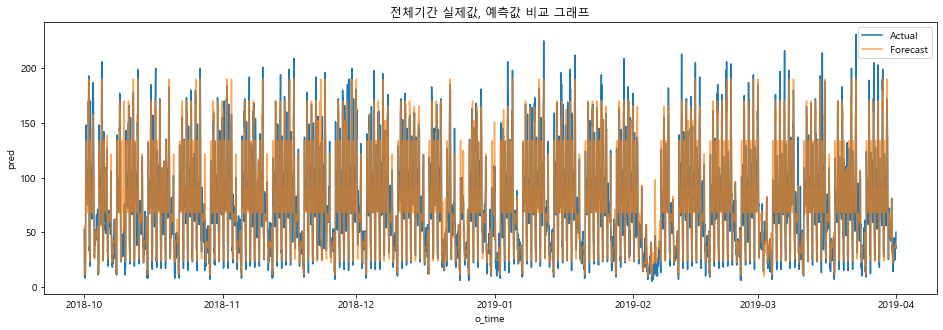

In [107]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=dt_taxi.index,y='count',data=dt_taxi)
sns.lineplot(x=dt_taxi.index,y='pred',data=dt_taxi,alpha=0.7)
plt.legend(['Actual','Forecast'])
plt.show()

##### 한달

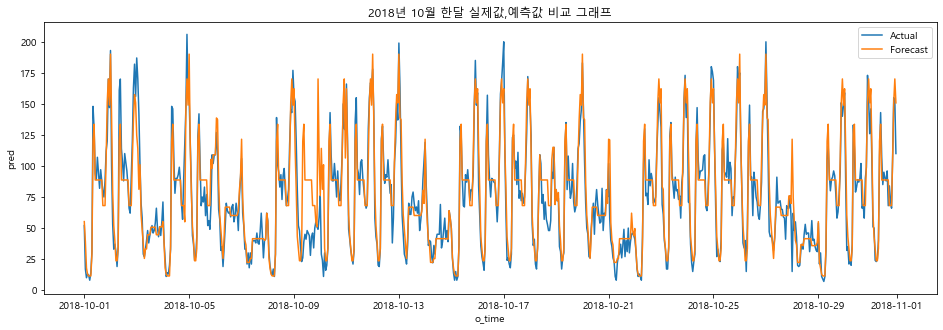

In [109]:
plt.figure(figsize=(16,5))
plt.title('2018년 10월 한달 실제값,예측값 비교 그래프')
sns.lineplot(x=dt_taxi['2018-10'].index,y='count',data=dt_taxi['2018-10'])
sns.lineplot(x=dt_taxi['2018-10'].index,y='pred',data=dt_taxi['2018-10'])
plt.legend(['Actual','Forecast'])
plt.show()

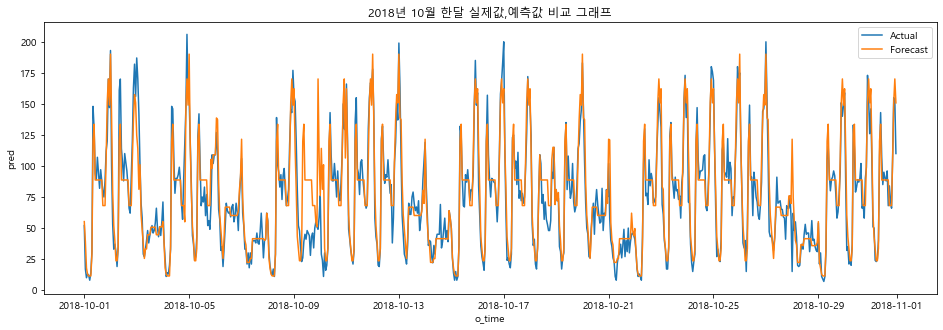

In [109]:
plt.figure(figsize=(16,5))
plt.title('2018년 10월 한달 실제값,예측값 비교 그래프')
sns.lineplot(x=dt_taxi['2018-10'].index,y='count',data=dt_taxi['2018-10'])
sns.lineplot(x=dt_taxi['2018-10'].index,y='pred',data=dt_taxi['2018-10'])
plt.legend(['Actual','Forecast'])
plt.show()

##### 일주일

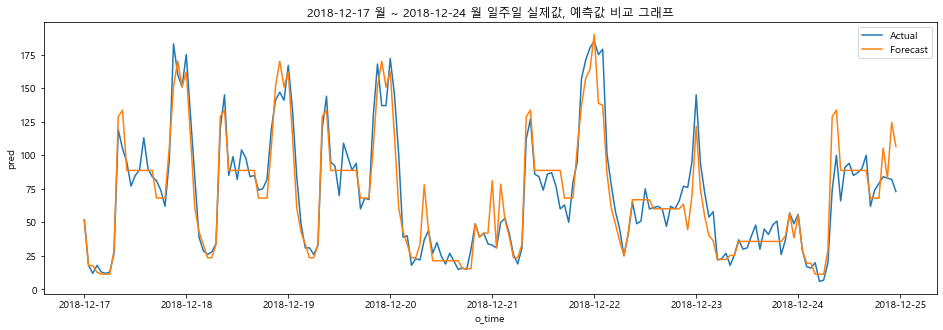

In [125]:
plt.figure(figsize=(16,5))
plt.title('2018-12-17 월 ~ 2018-12-24 월 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=dt_taxi['2018-12-17':'2018-12-24'].index,y='count',data=dt_taxi['2018-12-17':'2018-12-24'])
sns.lineplot(x=dt_taxi['2018-12-17':'2018-12-24'].index,y='pred',data=dt_taxi['2018-12-17':'2018-12-24'])
plt.legend(['Actual','Forecast'])
plt.show()

## RandomForest

In [16]:
rf_reg = RandomForestRegressor(random_state=0,n_estimators=200,max_depth= 8)
get_model_cv_prediction(rf_reg, X_data, y_target)

#####  RandomForestRegressor  #####
 4 교차검증 평균 RMSE : 17.575 


### 모델생성 & 평가

In [17]:
rf_model = rf_reg.fit(X_train,y_train)
pred = rf_model.predict(X_test)

evaluate_regr(y_test,pred)

MAE : 11.091, MSE : 254.311, RMSE : 15.947, RMSLE : 0.248


### 전체데이터 예측

#### 전체데이터에 예측값 컬럼 추가

In [18]:
pre = data.drop('count',axis=1,inplace=False)
pre

yesterday  today  tomorrow  temp  windspeed  humidity  cloud  \
0             1      0         0  14.1        2.6        55    0.0   
1             1      0         0  13.9        2.0        57    2.0   
2             1      0         0  13.9        2.4        56    4.0   
3             1      0         0  13.6        1.6        56    8.0   
4             1      0         0  13.7        1.9        56   10.0   
5             1      0         0  13.7        1.8        57    8.0   
6             1      0         0  13.3        2.3        56    7.0   
7             1      0         0  13.1        2.1        58    3.0   
8             1      0         0  13.7        2.4        54    7.0   
9             1      0         0  14.9        3.4        50    1.0   
10            1      0         0  16.3        3.6        47    2.0   
11            1      0         0  17.0        4.5        45    7.0   
12            1      0         0  18.4        3.5        40    6.0   
13            1      0         0  17.6        4.7        49    6.0   
14            1      0         0  19.3        3.5        36    6.0   
15            1      0         0  19.0        3.8        40    6.0   
16            1      0         0  17.7        3.4        47    9.0   
17            1      0         0  17.2        2.9        53    9.0   
18            1      0         0  16.6        2.9        61    8.0   
19            1      0         0  16.2        2.2        62    3.0   
20            1      0         0  15.4        2.1        63    5.0   
21            1      0         0  14.6        4.0        66    0.0   
22            1      0         0  13.9        0.5        69    0.0   
23            1      0         0  13.4        3.7        69    0.0   
24            0      0         1  13.0        1.8        72    0.0   
25            0      0         1  12.5        1.9        74    0.0   
26            0      0         1  12.3        1.6        75    0.0   
27            0      0         1  11.8        0.3        78    0.0   
28            0      0         1  11.2        0.3        80    0.0   
29            0      0         1  10.8        0.3        82    0.0   
...         ...    ...       ...   ...        ...       ...    ...   
4338          0      1         1   4.7        4.2        66   10.0   
4339          0      1         1   3.7        4.9        65   10.0   
4340          0      1         1   3.6        4.3        68    8.0   
4341          0      1         1   3.7        3.7        69    9.0   
4342          0      1         1   3.9        3.5        69    9.0   
4343          0      1         1   4.1        4.2        70    9.0   
4344          1      1         0   3.7        3.8        72    9.0   
4345          1      1         0   3.4        4.4        69    9.0   
4346          1      1         0   3.2        4.8        70    9.0   
4347          1      1         0   3.3        3.4        69    9.0   
4348          1      1         0   3.2        3.1        69    7.0   
4349          1      1         0   3.2        2.9        70    7.0   
4350          1      1         0   3.1        3.0        69    8.0   
4351          1      1         0   3.0        1.5        67    9.0   
4352          1      1         0   3.0        2.8        63    9.0   
4353          1      1         0   3.1        2.6        60    9.0   
4354          1      1         0   3.5        3.7        58    9.0   
4355          1      1         0   4.2        2.7        53    9.0   
4356          1      1         0   5.0        4.1        47    9.0   
4357          1      1         0   4.8        3.1        51    9.0   
4358          1      1         0   5.3        2.9        46    9.0   
4359          1      1         0   6.7        3.0        35    4.0   
4360          1      1         0   8.0        3.3        24    3.0   
4361          1      1         0   7.5        4.4        20    3.0   
4362          1      1         0   6.8        3.2        27    2.0   
4363          1 

In [20]:
rf_taxi = taxi.set_index('o_time',inplace=False)
rf_taxi['pred'] =rf_model.predict(pre)
rf_taxi

yesterday  today  tomorrow  temp  windspeed  humidity  \
o_time                                                                       
2018-10-01 00:00:00          1      0         0  14.1        2.6        55   
2018-10-01 01:00:00          1      0         0  13.9        2.0        57   
2018-10-01 02:00:00          1      0         0  13.9        2.4        56   
2018-10-01 03:00:00          1      0         0  13.6        1.6        56   
2018-10-01 04:00:00          1      0         0  13.7        1.9        56   
2018-10-01 05:00:00          1      0         0  13.7        1.8        57   
2018-10-01 06:00:00          1      0         0  13.3        2.3        56   
2018-10-01 07:00:00          1      0         0  13.1        2.1        58   
2018-10-01 08:00:00          1      0         0  13.7        2.4        54   
2018-10-01 09:00:00          1      0         0  14.9        3.4        50   
2018-10-01 10:00:00          1      0         0  16.3        3.6        47   
2018-10-01 11:00:00          1      0         0  17.0        4.5        45   
2018-10-01 12:00:00          1      0         0  18.4        3.5        40   
2018-10-01 13:00:00          1      0         0  17.6        4.7        49   
2018-10-01 14:00:00          1      0         0  19.3        3.5        36   
2018-10-01 15:00:00          1      0         0  19.0        3.8        40   
2018-10-01 16:00:00          1      0         0  17.7        3.4        47   
2018-10-01 17:00:00          1      0         0  17.2        2.9        53   
2018-10-01 18:00:00          1      0         0  16.6        2.9        61   
2018-10-01 19:00:00          1      0         0  16.2        2.2        62   
2018-10-01 20:00:00          1      0         0  15.4        2.1        63   
2018-10-01 21:00:00          1      0         0  14.6        4.0        66   
2018-10-01 22:00:00          1      0         0  13.9        0.5        69   
2018-10-01 23:00:00          1      0         0  13.4        3.7        69   
2018-10-02 00:00:00          0      0         1  13.0        1.8        72   
2018-10-02 01:00:00          0      0         1  12.5        1.9        74   
2018-10-02 02:00:00          0      0         1  12.3        1.6        75   
2018-10-02 03:00:00          0      0         1  11.8        0.3        78   
2018-10-02 04:00:00          0      0         1  11.2        0.3        80   
2018-10-02 05:00:00          0      0         1  10.8        0.3        82   
...                        ...    ...       ...   ...        ...       ...   
2019-03-30 18:00:00          0      1         1   4.7        4.2        66   
2019-03-30 19:00:00          0      1         1   3.7        4.9        65   
2019-03-30 20:00:00          0      1         1   3.6        4.3        68   
2019-03-30 21:00:00          0      1         1   3.7        3.7        69   
2019-03-30 22:00:00          0      1         1   3.9        3.5        69   
2019-03-30 23:00:00          0      1         1   4.1        4.2        70   
2019-03-31 00:00:00          1      1         0   3.7        3.8        72   
2019-03-31 01:00:00          1      1         0   3.4        4.4        69   
2019-03-31 02:00:00          1      1         0   3.2        4.8        70   
2019-03-31 03:00:00          1      1         0   3.3        3.4        69   
2019-03-31 04:00:00          1      1         0   3.2        3.1        69   
2019-03-31 05:00:00          1      1         0   3.2        2.9        70   
2019-03-31 06:00:00          1      1         0   3.1        3.0        69   
2019-03-31 07:00:00          1      1         0   3.0        1.5        67   
2019-03-31 08:00:00          1      1         0   3.0        2.8        63   
2019-03-31 09:00:00          1      1         0   3.1        2.6        60   
2019-03-31 10:00:00          1      1         0   3.5        3.7        58   
2019-03-31 11:00:00          1      1         0   4.2        2.7        53   
2019-03-31 12:00:00          1      1      

#### 실제값, 예측값 비교

##### 전체기간

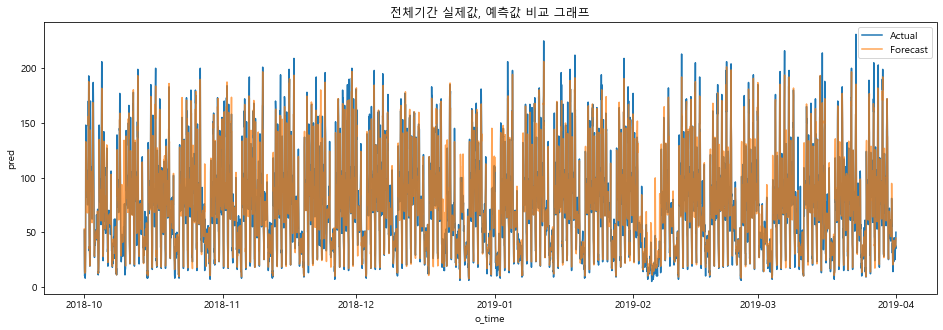

In [119]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=rf_taxi.index,y='count',data=rf_taxi)
sns.lineplot(x=rf_taxi.index,y='pred',data=rf_taxi,alpha=0.7)
plt.legend(['Actual','Forecast'])
plt.show()

##### 한달

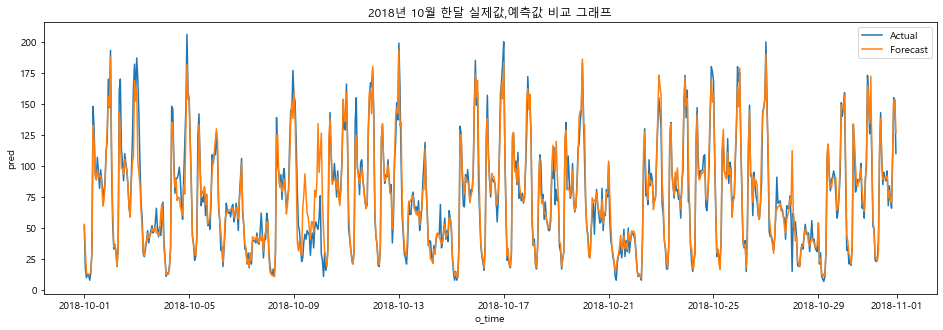

In [133]:
plt.figure(figsize=(16,5))
plt.title('2018년 10월 한달 실제값,예측값 비교 그래프')
sns.lineplot(x=rf_taxi['2018-10'].index,y='count',data=rf_taxi['2018-10'])
sns.lineplot(x=rf_taxi['2018-10'].index,y='pred',data=rf_taxi['2018-10'])
plt.legend(['Actual','Forecast'])
plt.show()

##### 일주일

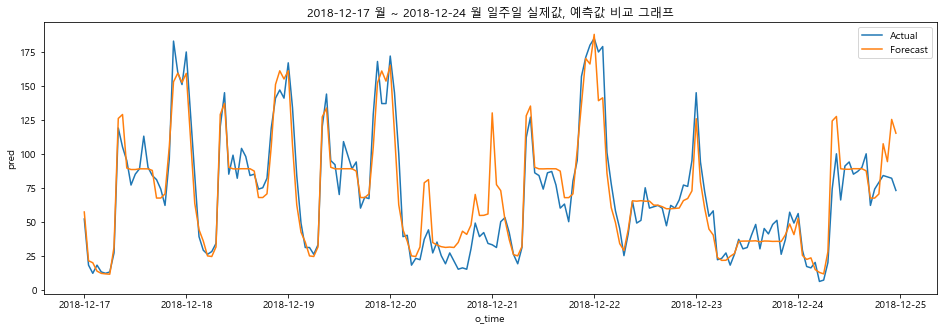

In [21]:
plt.figure(figsize=(16,5))
plt.title('2018-12-17 월 ~ 2018-12-24 월 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=rf_taxi['2018-12-17':'2018-12-24'].index,y='count',data=rf_taxi['2018-12-17':'2018-12-24'])
sns.lineplot(x=rf_taxi['2018-12-17':'2018-12-24'].index,y='pred',data=rf_taxi['2018-12-17':'2018-12-24'])
plt.legend(['Actual','Forecast'])
plt.show()

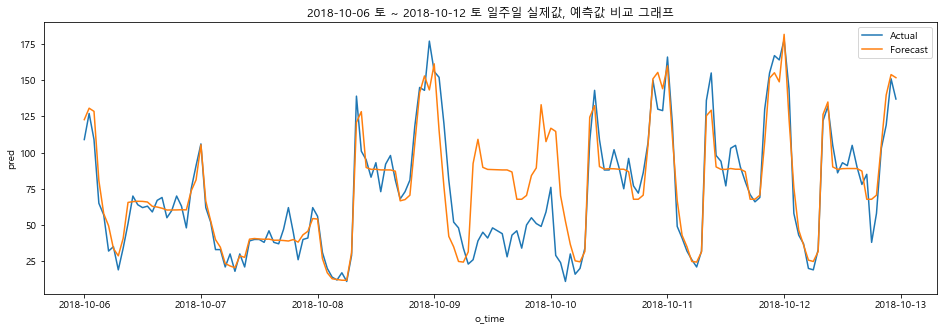

In [40]:
plt.figure(figsize=(16,5))
plt.title('2018-10-06 토 ~ 2018-10-12 토 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=rf_taxi['2018-10-06':'2018-10-12'].index,y='count',data=rf_taxi['2018-10-06':'2018-10-12'])
sns.lineplot(x=rf_taxi['2018-10-06':'2018-10-12'].index,y='pred',data=rf_taxi['2018-10-06':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

## GBM

In [219]:
gb_reg = GradientBoostingRegressor(random_state=0,n_estimators=300,learning_rate=0.06)
get_model_cv_prediction(gb_reg, X_data, y_target)

#####  GradientBoostingRegressor  #####
 4 교차검증 평균 RMSE : 17.041 


### 모델생성 & 평가

In [220]:
gb_model = gb_reg.fit(X_train,y_train)
pred = gb_model.predict(X_test)

evaluate_regr(y_test,pred)

MAE : 11.415, MSE : 247.824, RMSE : 15.742, RMSLE : 0.267


### 전체데이터 예측

#### 전체데이터에 예측값 컬럼 추가

In [127]:
pre = data.drop('count',axis=1,inplace=False)
pre

yesterday  today  tomorrow  temp  windspeed  humidity  cloud  \
0             1      0         0  14.1        2.6        55    0.0   
1             1      0         0  13.9        2.0        57    2.0   
2             1      0         0  13.9        2.4        56    4.0   
3             1      0         0  13.6        1.6        56    8.0   
4             1      0         0  13.7        1.9        56   10.0   
5             1      0         0  13.7        1.8        57    8.0   
6             1      0         0  13.3        2.3        56    7.0   
7             1      0         0  13.1        2.1        58    3.0   
8             1      0         0  13.7        2.4        54    7.0   
9             1      0         0  14.9        3.4        50    1.0   
10            1      0         0  16.3        3.6        47    2.0   
11            1      0         0  17.0        4.5        45    7.0   
12            1      0         0  18.4        3.5        40    6.0   
13            1      0         0  17.6        4.7        49    6.0   
14            1      0         0  19.3        3.5        36    6.0   
15            1      0         0  19.0        3.8        40    6.0   
16            1      0         0  17.7        3.4        47    9.0   
17            1      0         0  17.2        2.9        53    9.0   
18            1      0         0  16.6        2.9        61    8.0   
19            1      0         0  16.2        2.2        62    3.0   
20            1      0         0  15.4        2.1        63    5.0   
21            1      0         0  14.6        4.0        66    0.0   
22            1      0         0  13.9        0.5        69    0.0   
23            1      0         0  13.4        3.7        69    0.0   
24            0      0         1  13.0        1.8        72    0.0   
25            0      0         1  12.5        1.9        74    0.0   
26            0      0         1  12.3        1.6        75    0.0   
27            0      0         1  11.8        0.3        78    0.0   
28            0      0         1  11.2        0.3        80    0.0   
29            0      0         1  10.8        0.3        82    0.0   
...         ...    ...       ...   ...        ...       ...    ...   
4338          0      1         1   4.7        4.2        66   10.0   
4339          0      1         1   3.7        4.9        65   10.0   
4340          0      1         1   3.6        4.3        68    8.0   
4341          0      1         1   3.7        3.7        69    9.0   
4342          0      1         1   3.9        3.5        69    9.0   
4343          0      1         1   4.1        4.2        70    9.0   
4344          1      1         0   3.7        3.8        72    9.0   
4345          1      1         0   3.4        4.4        69    9.0   
4346          1      1         0   3.2        4.8        70    9.0   
4347          1      1         0   3.3        3.4        69    9.0   
4348          1      1         0   3.2        3.1        69    7.0   
4349          1      1         0   3.2        2.9        70    7.0   
4350          1      1         0   3.1        3.0        69    8.0   
4351          1      1         0   3.0        1.5        67    9.0   
4352          1      1         0   3.0        2.8        63    9.0   
4353          1      1         0   3.1        2.6        60    9.0   
4354          1      1         0   3.5        3.7        58    9.0   
4355          1      1         0   4.2        2.7        53    9.0   
4356          1      1         0   5.0        4.1        47    9.0   
4357          1      1         0   4.8        3.1        51    9.0   
4358          1      1         0   5.3        2.9        46    9.0   
4359          1      1         0   6.7        3.0        35    4.0   
4360          1      1         0   8.0        3.3        24    3.0   
4361          1      1         0   7.5        4.4        20    3.0   
4362          1      1         0   6.8        3.2        27    2.0   
4363          1 

In [128]:
gb_taxi = taxi.set_index('o_time',inplace=False)
gb_taxi['pred'] =gb_model.predict(pre)
gb_taxi

yesterday  today  tomorrow  temp  windspeed  humidity  \
o_time                                                                       
2018-10-01 00:00:00          1      0         0  14.1        2.6        55   
2018-10-01 01:00:00          1      0         0  13.9        2.0        57   
2018-10-01 02:00:00          1      0         0  13.9        2.4        56   
2018-10-01 03:00:00          1      0         0  13.6        1.6        56   
2018-10-01 04:00:00          1      0         0  13.7        1.9        56   
2018-10-01 05:00:00          1      0         0  13.7        1.8        57   
2018-10-01 06:00:00          1      0         0  13.3        2.3        56   
2018-10-01 07:00:00          1      0         0  13.1        2.1        58   
2018-10-01 08:00:00          1      0         0  13.7        2.4        54   
2018-10-01 09:00:00          1      0         0  14.9        3.4        50   
2018-10-01 10:00:00          1      0         0  16.3        3.6        47   
2018-10-01 11:00:00          1      0         0  17.0        4.5        45   
2018-10-01 12:00:00          1      0         0  18.4        3.5        40   
2018-10-01 13:00:00          1      0         0  17.6        4.7        49   
2018-10-01 14:00:00          1      0         0  19.3        3.5        36   
2018-10-01 15:00:00          1      0         0  19.0        3.8        40   
2018-10-01 16:00:00          1      0         0  17.7        3.4        47   
2018-10-01 17:00:00          1      0         0  17.2        2.9        53   
2018-10-01 18:00:00          1      0         0  16.6        2.9        61   
2018-10-01 19:00:00          1      0         0  16.2        2.2        62   
2018-10-01 20:00:00          1      0         0  15.4        2.1        63   
2018-10-01 21:00:00          1      0         0  14.6        4.0        66   
2018-10-01 22:00:00          1      0         0  13.9        0.5        69   
2018-10-01 23:00:00          1      0         0  13.4        3.7        69   
2018-10-02 00:00:00          0      0         1  13.0        1.8        72   
2018-10-02 01:00:00          0      0         1  12.5        1.9        74   
2018-10-02 02:00:00          0      0         1  12.3        1.6        75   
2018-10-02 03:00:00          0      0         1  11.8        0.3        78   
2018-10-02 04:00:00          0      0         1  11.2        0.3        80   
2018-10-02 05:00:00          0      0         1  10.8        0.3        82   
...                        ...    ...       ...   ...        ...       ...   
2019-03-30 18:00:00          0      1         1   4.7        4.2        66   
2019-03-30 19:00:00          0      1         1   3.7        4.9        65   
2019-03-30 20:00:00          0      1         1   3.6        4.3        68   
2019-03-30 21:00:00          0      1         1   3.7        3.7        69   
2019-03-30 22:00:00          0      1         1   3.9        3.5        69   
2019-03-30 23:00:00          0      1         1   4.1        4.2        70   
2019-03-31 00:00:00          1      1         0   3.7        3.8        72   
2019-03-31 01:00:00          1      1         0   3.4        4.4        69   
2019-03-31 02:00:00          1      1         0   3.2        4.8        70   
2019-03-31 03:00:00          1      1         0   3.3        3.4        69   
2019-03-31 04:00:00          1      1         0   3.2        3.1        69   
2019-03-31 05:00:00          1      1         0   3.2        2.9        70   
2019-03-31 06:00:00          1      1         0   3.1        3.0        69   
2019-03-31 07:00:00          1      1         0   3.0        1.5        67   
2019-03-31 08:00:00          1      1         0   3.0        2.8        63   
2019-03-31 09:00:00          1      1         0   3.1        2.6        60   
2019-03-31 10:00:00          1      1         0   3.5        3.7        58   
2019-03-31 11:00:00          1      1         0   4.2        2.7        53   
2019-03-31 12:00:00          1      1      

#### 실제값, 예측값 비교

##### 전체기간

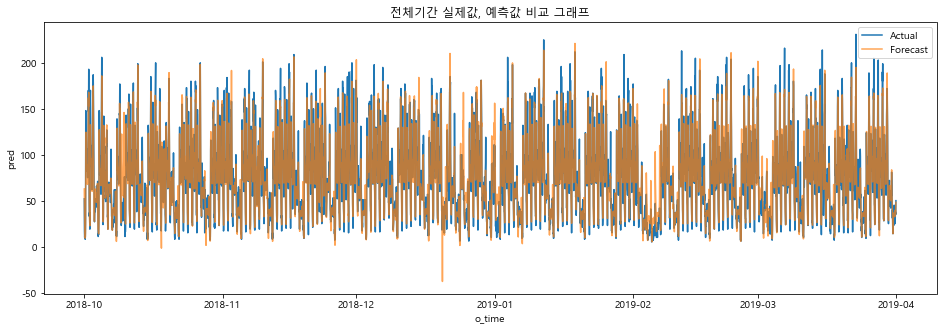

In [129]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=gb_taxi.index,y='count',data=gb_taxi)
sns.lineplot(x=gb_taxi.index,y='pred',data=gb_taxi,alpha=0.7)
plt.legend(['Actual','Forecast'])
plt.show()

##### 한달

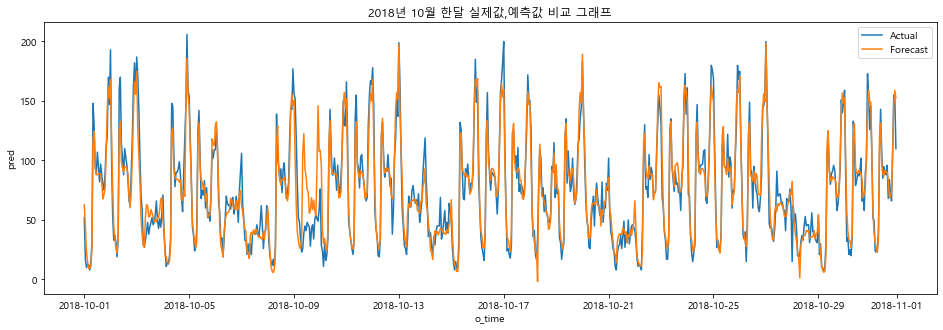

In [130]:
plt.figure(figsize=(16,5))
plt.title('2018년 10월 한달 실제값,예측값 비교 그래프')
sns.lineplot(x=gb_taxi['2018-10'].index,y='count',data=gb_taxi['2018-10'])
sns.lineplot(x=gb_taxi['2018-10'].index,y='pred',data=gb_taxi['2018-10'])
plt.legend(['Actual','Forecast'])
plt.show()

##### 일주일

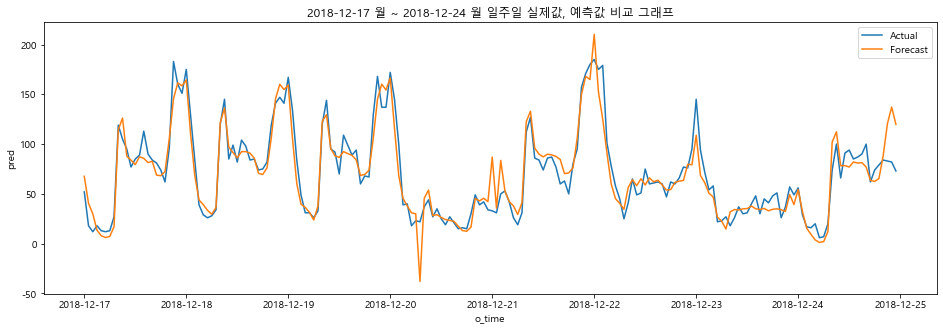

In [134]:
plt.figure(figsize=(16,5))
plt.title('2018-12-17 월 ~ 2018-12-24 월 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=gb_taxi['2018-12-17':'2018-12-24'].index,y='count',data=gb_taxi['2018-12-17':'2018-12-24'])
sns.lineplot(x=gb_taxi['2018-12-17':'2018-12-24'].index,y='pred',data=gb_taxi['2018-12-17':'2018-12-24'])
plt.legend(['Actual','Forecast'])
plt.show()

## XGBoost

In [26]:
xgb_reg = XGBRegressor(n_estimators=300, learning_rate=0.06, max_depth=5)
get_model_cv_prediction(xgb_reg, X_data, y_target)

[15:07:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#####  XGBRegressor  #####
 4 교차검증 평균 RMSE : 17.264 


### 모델생성 & 평가

In [27]:
xgb_model = xgb_reg.fit(X_train,y_train)
pred = xgb_model.predict(X_test)

evaluate_regr(y_test,pred)

[15:07:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 10.984, MSE : 237.027, RMSE : 15.396, RMSLE : 0.258


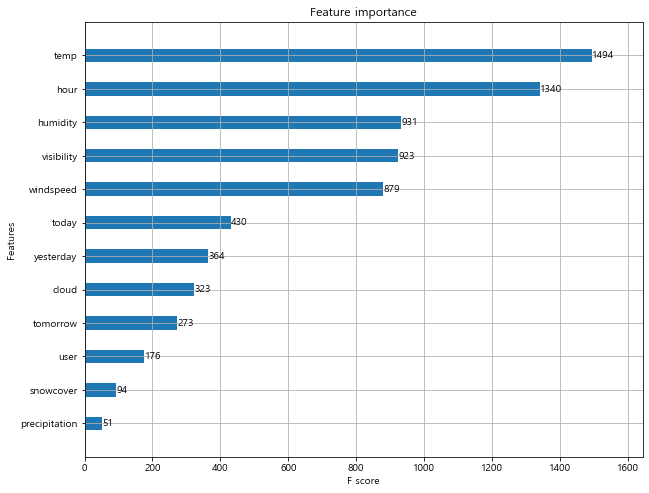

In [38]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_model, ax=ax, max_num_features=20, height=0.4)

### 전체데이터 예측

#### 전체데이터에 예측값 컬럼 추가

In [35]:
pre = data.drop('count',axis=1,inplace=False)
pre

yesterday  today  tomorrow  temp  windspeed  humidity  cloud  \
0             1      0         0  14.1        2.6        55    0.0   
1             1      0         0  13.9        2.0        57    2.0   
2             1      0         0  13.9        2.4        56    4.0   
3             1      0         0  13.6        1.6        56    8.0   
4             1      0         0  13.7        1.9        56   10.0   
5             1      0         0  13.7        1.8        57    8.0   
6             1      0         0  13.3        2.3        56    7.0   
7             1      0         0  13.1        2.1        58    3.0   
8             1      0         0  13.7        2.4        54    7.0   
9             1      0         0  14.9        3.4        50    1.0   
10            1      0         0  16.3        3.6        47    2.0   
11            1      0         0  17.0        4.5        45    7.0   
12            1      0         0  18.4        3.5        40    6.0   
13            1      0         0  17.6        4.7        49    6.0   
14            1      0         0  19.3        3.5        36    6.0   
15            1      0         0  19.0        3.8        40    6.0   
16            1      0         0  17.7        3.4        47    9.0   
17            1      0         0  17.2        2.9        53    9.0   
18            1      0         0  16.6        2.9        61    8.0   
19            1      0         0  16.2        2.2        62    3.0   
20            1      0         0  15.4        2.1        63    5.0   
21            1      0         0  14.6        4.0        66    0.0   
22            1      0         0  13.9        0.5        69    0.0   
23            1      0         0  13.4        3.7        69    0.0   
24            0      0         1  13.0        1.8        72    0.0   
25            0      0         1  12.5        1.9        74    0.0   
26            0      0         1  12.3        1.6        75    0.0   
27            0      0         1  11.8        0.3        78    0.0   
28            0      0         1  11.2        0.3        80    0.0   
29            0      0         1  10.8        0.3        82    0.0   
...         ...    ...       ...   ...        ...       ...    ...   
4338          0      1         1   4.7        4.2        66   10.0   
4339          0      1         1   3.7        4.9        65   10.0   
4340          0      1         1   3.6        4.3        68    8.0   
4341          0      1         1   3.7        3.7        69    9.0   
4342          0      1         1   3.9        3.5        69    9.0   
4343          0      1         1   4.1        4.2        70    9.0   
4344          1      1         0   3.7        3.8        72    9.0   
4345          1      1         0   3.4        4.4        69    9.0   
4346          1      1         0   3.2        4.8        70    9.0   
4347          1      1         0   3.3        3.4        69    9.0   
4348          1      1         0   3.2        3.1        69    7.0   
4349          1      1         0   3.2        2.9        70    7.0   
4350          1      1         0   3.1        3.0        69    8.0   
4351          1      1         0   3.0        1.5        67    9.0   
4352          1      1         0   3.0        2.8        63    9.0   
4353          1      1         0   3.1        2.6        60    9.0   
4354          1      1         0   3.5        3.7        58    9.0   
4355          1      1         0   4.2        2.7        53    9.0   
4356          1      1         0   5.0        4.1        47    9.0   
4357          1      1         0   4.8        3.1        51    9.0   
4358          1      1         0   5.3        2.9        46    9.0   
4359          1      1         0   6.7        3.0        35    4.0   
4360          1      1         0   8.0        3.3        24    3.0   
4361          1      1         0   7.5        4.4        20    3.0   
4362          1      1         0   6.8        3.2        27    2.0   
4363          1 

In [36]:
xgb_taxi = taxi.set_index('o_time',inplace=False)
xgb_taxi['pred'] =xgb_model.predict(pre)
xgb_taxi

yesterday  today  tomorrow  temp  windspeed  humidity  \
o_time                                                                       
2018-10-01 00:00:00          1      0         0  14.1        2.6        55   
2018-10-01 01:00:00          1      0         0  13.9        2.0        57   
2018-10-01 02:00:00          1      0         0  13.9        2.4        56   
2018-10-01 03:00:00          1      0         0  13.6        1.6        56   
2018-10-01 04:00:00          1      0         0  13.7        1.9        56   
2018-10-01 05:00:00          1      0         0  13.7        1.8        57   
2018-10-01 06:00:00          1      0         0  13.3        2.3        56   
2018-10-01 07:00:00          1      0         0  13.1        2.1        58   
2018-10-01 08:00:00          1      0         0  13.7        2.4        54   
2018-10-01 09:00:00          1      0         0  14.9        3.4        50   
2018-10-01 10:00:00          1      0         0  16.3        3.6        47   
2018-10-01 11:00:00          1      0         0  17.0        4.5        45   
2018-10-01 12:00:00          1      0         0  18.4        3.5        40   
2018-10-01 13:00:00          1      0         0  17.6        4.7        49   
2018-10-01 14:00:00          1      0         0  19.3        3.5        36   
2018-10-01 15:00:00          1      0         0  19.0        3.8        40   
2018-10-01 16:00:00          1      0         0  17.7        3.4        47   
2018-10-01 17:00:00          1      0         0  17.2        2.9        53   
2018-10-01 18:00:00          1      0         0  16.6        2.9        61   
2018-10-01 19:00:00          1      0         0  16.2        2.2        62   
2018-10-01 20:00:00          1      0         0  15.4        2.1        63   
2018-10-01 21:00:00          1      0         0  14.6        4.0        66   
2018-10-01 22:00:00          1      0         0  13.9        0.5        69   
2018-10-01 23:00:00          1      0         0  13.4        3.7        69   
2018-10-02 00:00:00          0      0         1  13.0        1.8        72   
2018-10-02 01:00:00          0      0         1  12.5        1.9        74   
2018-10-02 02:00:00          0      0         1  12.3        1.6        75   
2018-10-02 03:00:00          0      0         1  11.8        0.3        78   
2018-10-02 04:00:00          0      0         1  11.2        0.3        80   
2018-10-02 05:00:00          0      0         1  10.8        0.3        82   
...                        ...    ...       ...   ...        ...       ...   
2019-03-30 18:00:00          0      1         1   4.7        4.2        66   
2019-03-30 19:00:00          0      1         1   3.7        4.9        65   
2019-03-30 20:00:00          0      1         1   3.6        4.3        68   
2019-03-30 21:00:00          0      1         1   3.7        3.7        69   
2019-03-30 22:00:00          0      1         1   3.9        3.5        69   
2019-03-30 23:00:00          0      1         1   4.1        4.2        70   
2019-03-31 00:00:00          1      1         0   3.7        3.8        72   
2019-03-31 01:00:00          1      1         0   3.4        4.4        69   
2019-03-31 02:00:00          1      1         0   3.2        4.8        70   
2019-03-31 03:00:00          1      1         0   3.3        3.4        69   
2019-03-31 04:00:00          1      1         0   3.2        3.1        69   
2019-03-31 05:00:00          1      1         0   3.2        2.9        70   
2019-03-31 06:00:00          1      1         0   3.1        3.0        69   
2019-03-31 07:00:00          1      1         0   3.0        1.5        67   
2019-03-31 08:00:00          1      1         0   3.0        2.8        63   
2019-03-31 09:00:00          1      1         0   3.1        2.6        60   
2019-03-31 10:00:00          1      1         0   3.5        3.7        58   
2019-03-31 11:00:00          1      1         0   4.2        2.7        53   
2019-03-31 12:00:00          1      1      

#### 실제값, 예측값 비교

##### 전체기간

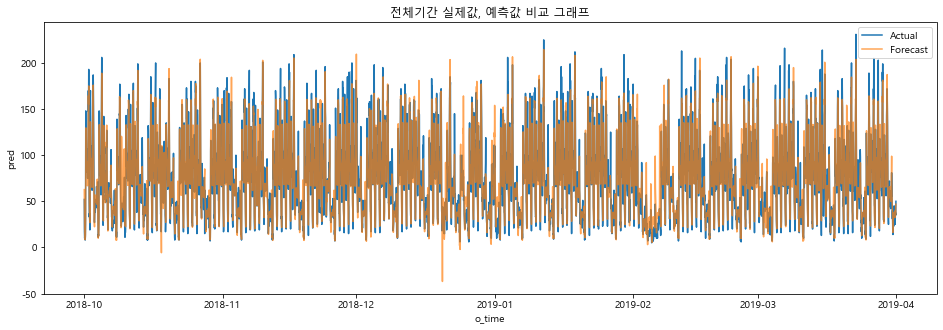

In [167]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=xgb_taxi.index,y='count',data=xgb_taxi)
sns.lineplot(x=xgb_taxi.index,y='pred',data=xgb_taxi,alpha=0.7)
plt.legend(['Actual','Forecast'])
plt.show()

##### 한달

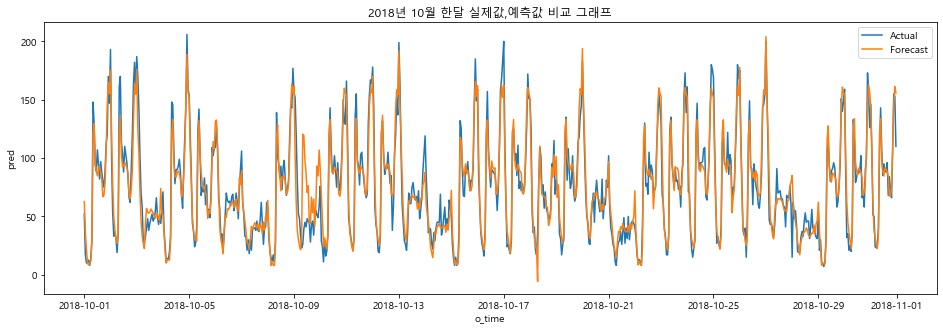

In [168]:
plt.figure(figsize=(16,5))
plt.title('2018년 10월 한달 실제값,예측값 비교 그래프')
sns.lineplot(x=xgb_taxi['2018-10'].index,y='count',data=xgb_taxi['2018-10'])
sns.lineplot(x=xgb_taxi['2018-10'].index,y='pred',data=xgb_taxi['2018-10'])
plt.legend(['Actual','Forecast'])
plt.show()

##### 일주일

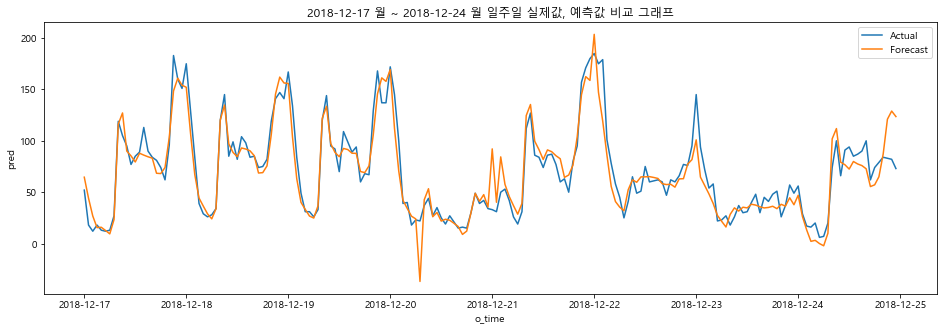

In [169]:
plt.figure(figsize=(16,5))
plt.title('2018-12-17 월 ~ 2018-12-24 월 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=xgb_taxi['2018-12-17':'2018-12-24'].index,y='count',data=xgb_taxi['2018-12-17':'2018-12-24'])
sns.lineplot(x=xgb_taxi['2018-12-17':'2018-12-24'].index,y='pred',data=xgb_taxi['2018-12-17':'2018-12-24'])
plt.legend(['Actual','Forecast'])
plt.show()

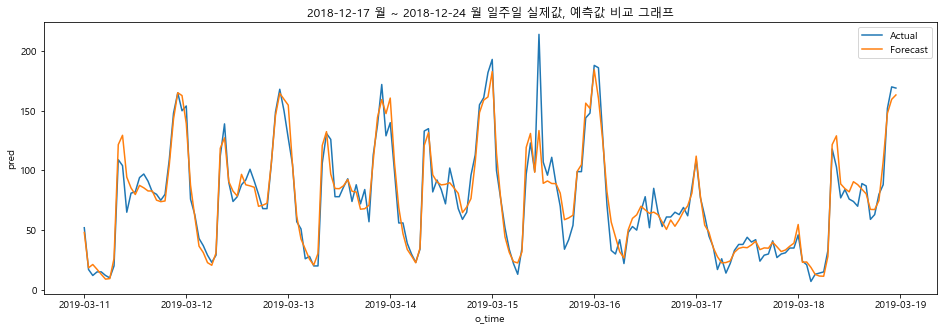

In [37]:
plt.figure(figsize=(16,5))
plt.title('2018-12-17 월 ~ 2018-12-24 월 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=xgb_taxi['2019-03-11':'2019-03-18'].index,y='count',data=xgb_taxi['2019-03-11':'2019-03-18'])
sns.lineplot(x=xgb_taxi['2019-03-11':'2019-03-18'].index,y='pred',data=xgb_taxi['2019-03-11':'2019-03-18'])
plt.legend(['Actual','Forecast'])
plt.show()

## feature, target 데이터변환

__선형회귀 모델은 피쳐값과 타깃값의 분포가 정규분포 형태를 매우 선호함.__  
--> __특히 타깃값의 경우 정규분포 형태가 아닌 특정값의 분포가 치우친 왜곡된 형태의 분포도일 경우 예측 성능에 부정적인 영향을 미칠 가능성이 높음.__  
--> __피쳐값 역시 타깃값 보다는 덜 하지만 왜곡된 분포도로 인해 예측성능에 부정적인 영향을 미칠 수 있음.__

### feature - MinMaxScaling

In [327]:
y_target = data['count']
X_data = data.drop(['count'], axis=1, inplace=False)

In [328]:
X_data2 = MinMaxScaler().fit_transform(X_data)
scaled_data = PolynomialFeatures(degree=2,include_bias=False).fit_transform(X_data2)
scaled_data

array([[1.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 1.        , 0.04347826,
        0.00189036],
       [1.        , 0.        , 0.        , ..., 1.        , 0.08695652,
        0.00756144],
       ...,
       [1.        , 1.        , 0.        , ..., 1.        , 0.91304348,
        0.83364839],
       [1.        , 1.        , 0.        , ..., 1.        , 0.95652174,
        0.91493384],
       [1.        , 1.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

### target - log 변환

##### target 분포 확인

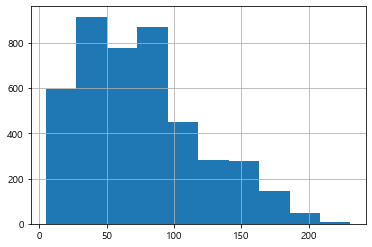

In [329]:
y_target.hist()

##### target log 변환

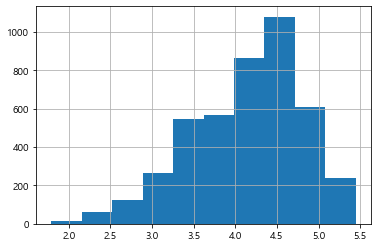

In [330]:
y_target_log = np.log1p(y_target)
y_target_log.hist()

### train, test 데이터셋 분리

In [344]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y_target_log, test_size=0.3, random_state=156)

### 모델과 훈련/테스트 데이터셋을 입력하면 성능평가 수치 반환 함수 작성

In [307]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('##### ',model.__class__.__name__,' #####')
    evaluate_regr(y_test,pred)

#### DecisionTree, RandomForest, GBM, XGB 성능평가 

In [345]:
for model in [dt_reg, rf_reg, gb_reg, xgb_reg]:
    get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=True)

#####  DecisionTreeRegressor  #####
MAE : 11.484, MSE : 274.716, RMSE : 16.575, RMSLE : 0.253
#####  RandomForestRegressor  #####
MAE : 10.355, MSE : 218.887, RMSE : 14.795, RMSLE : 0.215
#####  GradientBoostingRegressor  #####
MAE : 10.852, MSE : 231.025, RMSE : 15.200, RMSLE : 0.217
[16:51:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#####  XGBRegressor  #####
MAE : 10.034, MSE : 194.702, RMSE : 13.954, RMSLE : 0.204


### 전체데이터 예측

#### 예측하기 위한 전체데이터 셋팅

In [360]:
pre = data.drop('count',axis=1,inplace=False)
pre

yesterday  today  tomorrow  temp  windspeed  humidity  cloud  \
0             1      0         0  14.1        2.6        55    0.0   
1             1      0         0  13.9        2.0        57    2.0   
2             1      0         0  13.9        2.4        56    4.0   
3             1      0         0  13.6        1.6        56    8.0   
4             1      0         0  13.7        1.9        56   10.0   
5             1      0         0  13.7        1.8        57    8.0   
6             1      0         0  13.3        2.3        56    7.0   
7             1      0         0  13.1        2.1        58    3.0   
8             1      0         0  13.7        2.4        54    7.0   
9             1      0         0  14.9        3.4        50    1.0   
10            1      0         0  16.3        3.6        47    2.0   
11            1      0         0  17.0        4.5        45    7.0   
12            1      0         0  18.4        3.5        40    6.0   
13            1      0         0  17.6        4.7        49    6.0   
14            1      0         0  19.3        3.5        36    6.0   
15            1      0         0  19.0        3.8        40    6.0   
16            1      0         0  17.7        3.4        47    9.0   
17            1      0         0  17.2        2.9        53    9.0   
18            1      0         0  16.6        2.9        61    8.0   
19            1      0         0  16.2        2.2        62    3.0   
20            1      0         0  15.4        2.1        63    5.0   
21            1      0         0  14.6        4.0        66    0.0   
22            1      0         0  13.9        0.5        69    0.0   
23            1      0         0  13.4        3.7        69    0.0   
24            0      0         1  13.0        1.8        72    0.0   
25            0      0         1  12.5        1.9        74    0.0   
26            0      0         1  12.3        1.6        75    0.0   
27            0      0         1  11.8        0.3        78    0.0   
28            0      0         1  11.2        0.3        80    0.0   
29            0      0         1  10.8        0.3        82    0.0   
...         ...    ...       ...   ...        ...       ...    ...   
4338          0      1         1   4.7        4.2        66   10.0   
4339          0      1         1   3.7        4.9        65   10.0   
4340          0      1         1   3.6        4.3        68    8.0   
4341          0      1         1   3.7        3.7        69    9.0   
4342          0      1         1   3.9        3.5        69    9.0   
4343          0      1         1   4.1        4.2        70    9.0   
4344          1      1         0   3.7        3.8        72    9.0   
4345          1      1         0   3.4        4.4        69    9.0   
4346          1      1         0   3.2        4.8        70    9.0   
4347          1      1         0   3.3        3.4        69    9.0   
4348          1      1         0   3.2        3.1        69    7.0   
4349          1      1         0   3.2        2.9        70    7.0   
4350          1      1         0   3.1        3.0        69    8.0   
4351          1      1         0   3.0        1.5        67    9.0   
4352          1      1         0   3.0        2.8        63    9.0   
4353          1      1         0   3.1        2.6        60    9.0   
4354          1      1         0   3.5        3.7        58    9.0   
4355          1      1         0   4.2        2.7        53    9.0   
4356          1      1         0   5.0        4.1        47    9.0   
4357          1      1         0   4.8        3.1        51    9.0   
4358          1      1         0   5.3        2.9        46    9.0   
4359          1      1         0   6.7        3.0        35    4.0   
4360          1      1         0   8.0        3.3        24    3.0   
4361          1      1         0   7.5        4.4        20    3.0   
4362          1      1         0   6.8        3.2        27    2.0   
4363          1 

In [361]:
pre2 = MinMaxScaler().fit_transform(pre)
scaled_data2 = PolynomialFeatures(degree=2,include_bias=False).fit_transform(pre2)
scaled_data2

array([[1.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 1.        , 0.04347826,
        0.00189036],
       [1.        , 0.        , 0.        , ..., 1.        , 0.08695652,
        0.00756144],
       ...,
       [1.        , 1.        , 0.        , ..., 1.        , 0.91304348,
        0.83364839],
       [1.        , 1.        , 0.        , ..., 1.        , 0.95652174,
        0.91493384],
       [1.        , 1.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

#### DecisionTree

In [359]:
dt_reg = DecisionTreeRegressor(random_state=0,max_depth=7)
dt_model = dt_reg.fit(X_train,y_train)
pred = dt_model.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp,pred_exp)

MAE : 11.484, MSE : 274.716, RMSE : 16.575, RMSLE : 0.253


##### 전체데이터 예측 성능평가

In [366]:
dt_pred = dt_model.predict(scaled_data2)
dt_pred_exp = np.expm1(dt_pred)
evaluate_regr(y_target,dt_pred_exp)

MAE : 10.350, MSE : 220.348, RMSE : 14.844, RMSLE : 0.216


##### DecisionTree 모델 예측값 컬럼 추가

In [364]:
dt_taxi2 = taxi.set_index('o_time',inplace=False)
dt_taxi2['pred'] = dt_pred_exp
dt_taxi2

yesterday  today  tomorrow  temp  windspeed  humidity  \
o_time                                                                       
2018-10-01 00:00:00          1      0         0  14.1        2.6        55   
2018-10-01 01:00:00          1      0         0  13.9        2.0        57   
2018-10-01 02:00:00          1      0         0  13.9        2.4        56   
2018-10-01 03:00:00          1      0         0  13.6        1.6        56   
2018-10-01 04:00:00          1      0         0  13.7        1.9        56   
2018-10-01 05:00:00          1      0         0  13.7        1.8        57   
2018-10-01 06:00:00          1      0         0  13.3        2.3        56   
2018-10-01 07:00:00          1      0         0  13.1        2.1        58   
2018-10-01 08:00:00          1      0         0  13.7        2.4        54   
2018-10-01 09:00:00          1      0         0  14.9        3.4        50   
2018-10-01 10:00:00          1      0         0  16.3        3.6        47   
2018-10-01 11:00:00          1      0         0  17.0        4.5        45   
2018-10-01 12:00:00          1      0         0  18.4        3.5        40   
2018-10-01 13:00:00          1      0         0  17.6        4.7        49   
2018-10-01 14:00:00          1      0         0  19.3        3.5        36   
2018-10-01 15:00:00          1      0         0  19.0        3.8        40   
2018-10-01 16:00:00          1      0         0  17.7        3.4        47   
2018-10-01 17:00:00          1      0         0  17.2        2.9        53   
2018-10-01 18:00:00          1      0         0  16.6        2.9        61   
2018-10-01 19:00:00          1      0         0  16.2        2.2        62   
2018-10-01 20:00:00          1      0         0  15.4        2.1        63   
2018-10-01 21:00:00          1      0         0  14.6        4.0        66   
2018-10-01 22:00:00          1      0         0  13.9        0.5        69   
2018-10-01 23:00:00          1      0         0  13.4        3.7        69   
2018-10-02 00:00:00          0      0         1  13.0        1.8        72   
2018-10-02 01:00:00          0      0         1  12.5        1.9        74   
2018-10-02 02:00:00          0      0         1  12.3        1.6        75   
2018-10-02 03:00:00          0      0         1  11.8        0.3        78   
2018-10-02 04:00:00          0      0         1  11.2        0.3        80   
2018-10-02 05:00:00          0      0         1  10.8        0.3        82   
...                        ...    ...       ...   ...        ...       ...   
2019-03-30 18:00:00          0      1         1   4.7        4.2        66   
2019-03-30 19:00:00          0      1         1   3.7        4.9        65   
2019-03-30 20:00:00          0      1         1   3.6        4.3        68   
2019-03-30 21:00:00          0      1         1   3.7        3.7        69   
2019-03-30 22:00:00          0      1         1   3.9        3.5        69   
2019-03-30 23:00:00          0      1         1   4.1        4.2        70   
2019-03-31 00:00:00          1      1         0   3.7        3.8        72   
2019-03-31 01:00:00          1      1         0   3.4        4.4        69   
2019-03-31 02:00:00          1      1         0   3.2        4.8        70   
2019-03-31 03:00:00          1      1         0   3.3        3.4        69   
2019-03-31 04:00:00          1      1         0   3.2        3.1        69   
2019-03-31 05:00:00          1      1         0   3.2        2.9        70   
2019-03-31 06:00:00          1      1         0   3.1        3.0        69   
2019-03-31 07:00:00          1      1         0   3.0        1.5        67   
2019-03-31 08:00:00          1      1         0   3.0        2.8        63   
2019-03-31 09:00:00          1      1         0   3.1        2.6        60   
2019-03-31 10:00:00          1      1         0   3.5        3.7        58   
2019-03-31 11:00:00          1      1         0   4.2        2.7        53   
2019-03-31 12:00:00          1      1      

##### 실제값 예측값 비교 

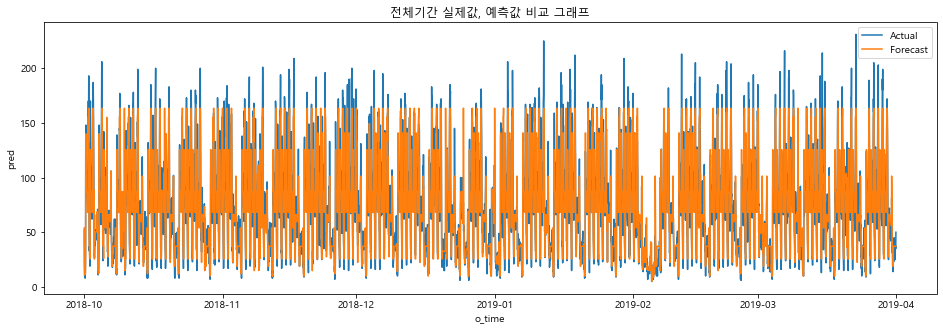

In [418]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=dt_taxi2.index,y='count',data=dt_taxi2)
sns.lineplot(x=dt_taxi2.index,y='pred',data=dt_taxi2)
plt.legend(['Actual','Forecast'])
plt.show()

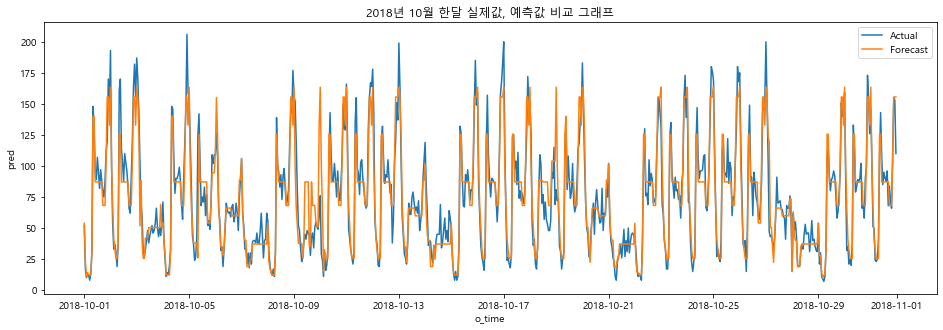

In [419]:
plt.figure(figsize=(16,5))
plt.title('2018년 10월 한달 실제값, 예측값 비교 그래프')
sns.lineplot(x=dt_taxi2['2018-10'].index,y='count',data=dt_taxi2['2018-10'])
sns.lineplot(x=dt_taxi2['2018-10'].index,y='pred',data=dt_taxi2['2018-10'])
plt.legend(['Actual','Forecast'])
plt.show()

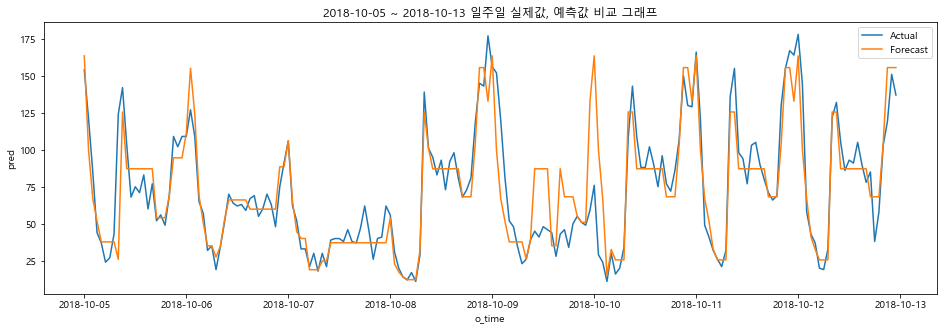

In [420]:
plt.figure(figsize=(16,5))
plt.title('2018-10-05 ~ 2018-10-13 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=dt_taxi2['2018-10-05':'2018-10-12'].index,y='count',data=dt_taxi2['2018-10-05':'2018-10-12'])
sns.lineplot(x=dt_taxi2['2018-10-05':'2018-10-12'].index,y='pred',data=dt_taxi2['2018-10-05':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

#### RandomForest

In [365]:
rf_reg = RandomForestRegressor(random_state=0,n_estimators=200,max_depth= 8)
rf_model = rf_reg.fit(X_train,y_train)
pred = rf_model.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp,pred_exp)

MAE : 10.355, MSE : 218.887, RMSE : 14.795, RMSLE : 0.215


##### 전체데이터 예측 성능 평가

In [367]:
rf_pred = rf_model.predict(scaled_data2)
rf_pred_exp = np.expm1(rf_pred)
evaluate_regr(y_target,rf_pred_exp)

MAE : 9.080, MSE : 165.916, RMSE : 12.881, RMSLE : 0.181


##### RandomForest 모델 예측값 컬럼 추가

In [368]:
rf_taxi2 = taxi.set_index('o_time',inplace=False)
rf_taxi2['pred'] = rf_pred_exp
rf_taxi2

yesterday  today  tomorrow  temp  windspeed  humidity  \
o_time                                                                       
2018-10-01 00:00:00          1      0         0  14.1        2.6        55   
2018-10-01 01:00:00          1      0         0  13.9        2.0        57   
2018-10-01 02:00:00          1      0         0  13.9        2.4        56   
2018-10-01 03:00:00          1      0         0  13.6        1.6        56   
2018-10-01 04:00:00          1      0         0  13.7        1.9        56   
2018-10-01 05:00:00          1      0         0  13.7        1.8        57   
2018-10-01 06:00:00          1      0         0  13.3        2.3        56   
2018-10-01 07:00:00          1      0         0  13.1        2.1        58   
2018-10-01 08:00:00          1      0         0  13.7        2.4        54   
2018-10-01 09:00:00          1      0         0  14.9        3.4        50   
2018-10-01 10:00:00          1      0         0  16.3        3.6        47   
2018-10-01 11:00:00          1      0         0  17.0        4.5        45   
2018-10-01 12:00:00          1      0         0  18.4        3.5        40   
2018-10-01 13:00:00          1      0         0  17.6        4.7        49   
2018-10-01 14:00:00          1      0         0  19.3        3.5        36   
2018-10-01 15:00:00          1      0         0  19.0        3.8        40   
2018-10-01 16:00:00          1      0         0  17.7        3.4        47   
2018-10-01 17:00:00          1      0         0  17.2        2.9        53   
2018-10-01 18:00:00          1      0         0  16.6        2.9        61   
2018-10-01 19:00:00          1      0         0  16.2        2.2        62   
2018-10-01 20:00:00          1      0         0  15.4        2.1        63   
2018-10-01 21:00:00          1      0         0  14.6        4.0        66   
2018-10-01 22:00:00          1      0         0  13.9        0.5        69   
2018-10-01 23:00:00          1      0         0  13.4        3.7        69   
2018-10-02 00:00:00          0      0         1  13.0        1.8        72   
2018-10-02 01:00:00          0      0         1  12.5        1.9        74   
2018-10-02 02:00:00          0      0         1  12.3        1.6        75   
2018-10-02 03:00:00          0      0         1  11.8        0.3        78   
2018-10-02 04:00:00          0      0         1  11.2        0.3        80   
2018-10-02 05:00:00          0      0         1  10.8        0.3        82   
...                        ...    ...       ...   ...        ...       ...   
2019-03-30 18:00:00          0      1         1   4.7        4.2        66   
2019-03-30 19:00:00          0      1         1   3.7        4.9        65   
2019-03-30 20:00:00          0      1         1   3.6        4.3        68   
2019-03-30 21:00:00          0      1         1   3.7        3.7        69   
2019-03-30 22:00:00          0      1         1   3.9        3.5        69   
2019-03-30 23:00:00          0      1         1   4.1        4.2        70   
2019-03-31 00:00:00          1      1         0   3.7        3.8        72   
2019-03-31 01:00:00          1      1         0   3.4        4.4        69   
2019-03-31 02:00:00          1      1         0   3.2        4.8        70   
2019-03-31 03:00:00          1      1         0   3.3        3.4        69   
2019-03-31 04:00:00          1      1         0   3.2        3.1        69   
2019-03-31 05:00:00          1      1         0   3.2        2.9        70   
2019-03-31 06:00:00          1      1         0   3.1        3.0        69   
2019-03-31 07:00:00          1      1         0   3.0        1.5        67   
2019-03-31 08:00:00          1      1         0   3.0        2.8        63   
2019-03-31 09:00:00          1      1         0   3.1        2.6        60   
2019-03-31 10:00:00          1      1         0   3.5        3.7        58   
2019-03-31 11:00:00          1      1         0   4.2        2.7        53   
2019-03-31 12:00:00          1      1      

##### 실제값 예측값 비교

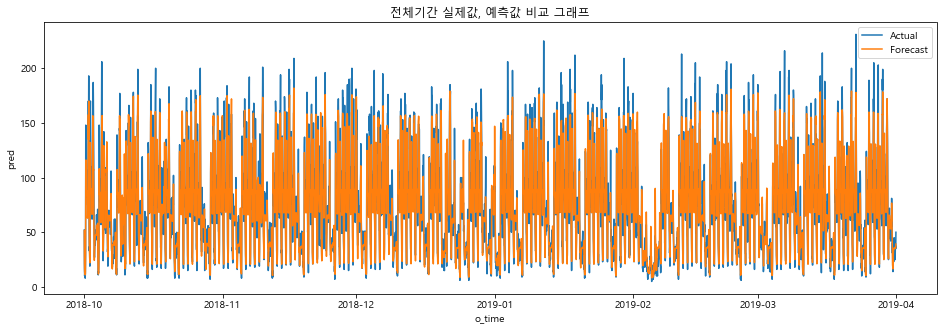

In [415]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=rf_taxi2.index,y='count',data=rf_taxi2)
sns.lineplot(x=rf_taxi2.index,y='pred',data=rf_taxi2)
plt.legend(['Actual','Forecast'])
plt.show()

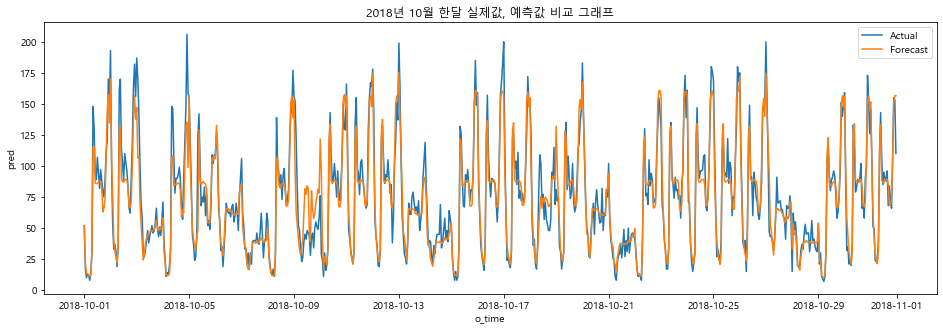

In [416]:
plt.figure(figsize=(16,5))
plt.title('2018년 10월 한달 실제값, 예측값 비교 그래프')
sns.lineplot(x=rf_taxi2['2018-10'].index,y='count',data=rf_taxi2['2018-10'])
sns.lineplot(x=rf_taxi2['2018-10'].index,y='pred',data=rf_taxi2['2018-10'])
plt.legend(['Actual','Forecast'])
plt.show()

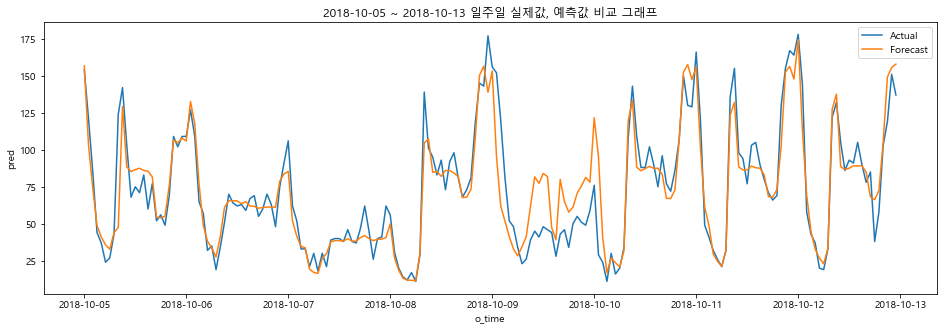

In [417]:
plt.figure(figsize=(16,5))
plt.title('2018-10-05 ~ 2018-10-13 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=rf_taxi2['2018-10-05':'2018-10-12'].index,y='count',data=rf_taxi2['2018-10-05':'2018-10-12'])
sns.lineplot(x=rf_taxi2['2018-10-05':'2018-10-12'].index,y='pred',data=rf_taxi2['2018-10-05':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

#### GBM

In [381]:
gb_reg = GradientBoostingRegressor(random_state=0,n_estimators=600,learning_rate=0.08)
gb_model = gb_reg.fit(X_train,y_train)
pred = gb_model.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp,pred_exp)

MAE : 10.310, MSE : 205.586, RMSE : 14.338, RMSLE : 0.208


##### 전체데이터 예측 성능평가

In [382]:
gb_pred = gb_model.predict(scaled_data2)
gb_pred_exp = np.expm1(gb_pred)
evaluate_regr(y_target,gb_pred_exp)

MAE : 8.180, MSE : 136.271, RMSE : 11.674, RMSLE : 0.162


##### GBM 모델 예측값 컬럼 추가

In [383]:
gb_taxi2 = taxi.set_index('o_time',inplace=False)
gb_taxi2['pred'] = gb_pred_exp
gb_taxi2

yesterday  today  tomorrow  temp  windspeed  humidity  \
o_time                                                                       
2018-10-01 00:00:00          1      0         0  14.1        2.6        55   
2018-10-01 01:00:00          1      0         0  13.9        2.0        57   
2018-10-01 02:00:00          1      0         0  13.9        2.4        56   
2018-10-01 03:00:00          1      0         0  13.6        1.6        56   
2018-10-01 04:00:00          1      0         0  13.7        1.9        56   
2018-10-01 05:00:00          1      0         0  13.7        1.8        57   
2018-10-01 06:00:00          1      0         0  13.3        2.3        56   
2018-10-01 07:00:00          1      0         0  13.1        2.1        58   
2018-10-01 08:00:00          1      0         0  13.7        2.4        54   
2018-10-01 09:00:00          1      0         0  14.9        3.4        50   
2018-10-01 10:00:00          1      0         0  16.3        3.6        47   
2018-10-01 11:00:00          1      0         0  17.0        4.5        45   
2018-10-01 12:00:00          1      0         0  18.4        3.5        40   
2018-10-01 13:00:00          1      0         0  17.6        4.7        49   
2018-10-01 14:00:00          1      0         0  19.3        3.5        36   
2018-10-01 15:00:00          1      0         0  19.0        3.8        40   
2018-10-01 16:00:00          1      0         0  17.7        3.4        47   
2018-10-01 17:00:00          1      0         0  17.2        2.9        53   
2018-10-01 18:00:00          1      0         0  16.6        2.9        61   
2018-10-01 19:00:00          1      0         0  16.2        2.2        62   
2018-10-01 20:00:00          1      0         0  15.4        2.1        63   
2018-10-01 21:00:00          1      0         0  14.6        4.0        66   
2018-10-01 22:00:00          1      0         0  13.9        0.5        69   
2018-10-01 23:00:00          1      0         0  13.4        3.7        69   
2018-10-02 00:00:00          0      0         1  13.0        1.8        72   
2018-10-02 01:00:00          0      0         1  12.5        1.9        74   
2018-10-02 02:00:00          0      0         1  12.3        1.6        75   
2018-10-02 03:00:00          0      0         1  11.8        0.3        78   
2018-10-02 04:00:00          0      0         1  11.2        0.3        80   
2018-10-02 05:00:00          0      0         1  10.8        0.3        82   
...                        ...    ...       ...   ...        ...       ...   
2019-03-30 18:00:00          0      1         1   4.7        4.2        66   
2019-03-30 19:00:00          0      1         1   3.7        4.9        65   
2019-03-30 20:00:00          0      1         1   3.6        4.3        68   
2019-03-30 21:00:00          0      1         1   3.7        3.7        69   
2019-03-30 22:00:00          0      1         1   3.9        3.5        69   
2019-03-30 23:00:00          0      1         1   4.1        4.2        70   
2019-03-31 00:00:00          1      1         0   3.7        3.8        72   
2019-03-31 01:00:00          1      1         0   3.4        4.4        69   
2019-03-31 02:00:00          1      1         0   3.2        4.8        70   
2019-03-31 03:00:00          1      1         0   3.3        3.4        69   
2019-03-31 04:00:00          1      1         0   3.2        3.1        69   
2019-03-31 05:00:00          1      1         0   3.2        2.9        70   
2019-03-31 06:00:00          1      1         0   3.1        3.0        69   
2019-03-31 07:00:00          1      1         0   3.0        1.5        67   
2019-03-31 08:00:00          1      1         0   3.0        2.8        63   
2019-03-31 09:00:00          1      1         0   3.1        2.6        60   
2019-03-31 10:00:00          1      1         0   3.5        3.7        58   
2019-03-31 11:00:00          1      1         0   4.2        2.7        53   
2019-03-31 12:00:00          1      1      

##### 실제값 예측값 비교

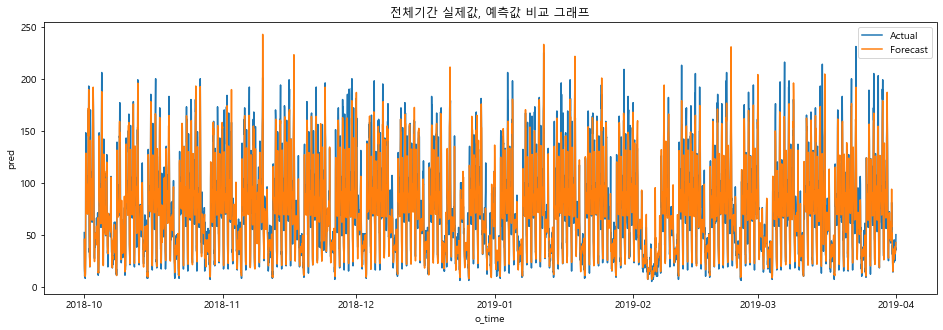

In [412]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=gb_taxi2.index,y='count',data=gb_taxi2)
sns.lineplot(x=gb_taxi2.index,y='pred',data=gb_taxi2)
plt.legend(['Actual','Forecast'])
plt.show()

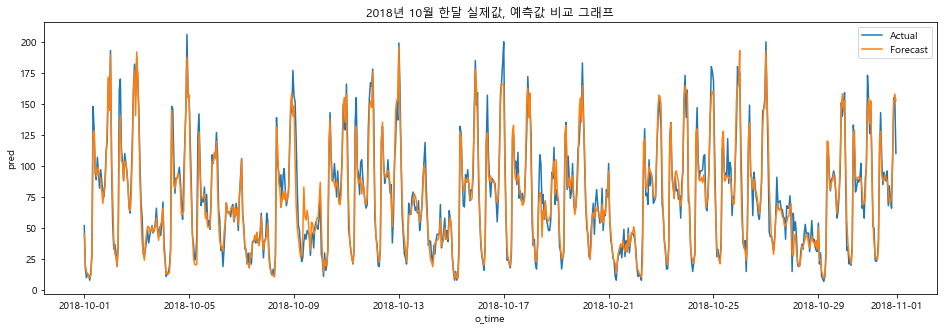

In [413]:
plt.figure(figsize=(16,5))
plt.title('2018년 10월 한달 실제값, 예측값 비교 그래프')
sns.lineplot(x=gb_taxi2['2018-10'].index,y='count',data=gb_taxi2['2018-10'])
sns.lineplot(x=gb_taxi2['2018-10'].index,y='pred',data=gb_taxi2['2018-10'])
plt.legend(['Actual','Forecast'])
plt.show()

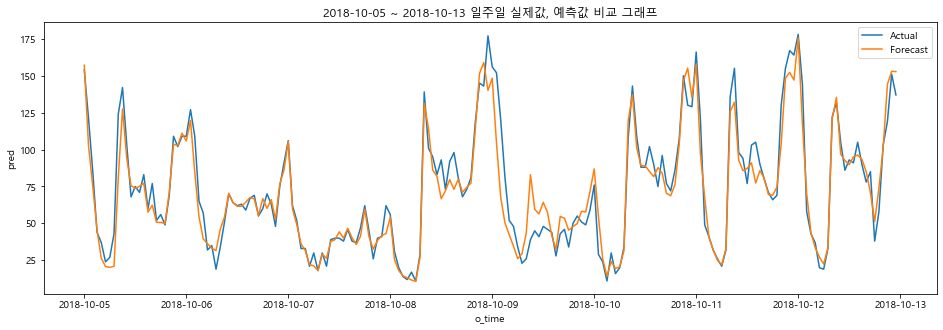

In [414]:
plt.figure(figsize=(16,5))
plt.title('2018-10-05 ~ 2018-10-13 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=gb_taxi2['2018-10-05':'2018-10-12'].index,y='count',data=gb_taxi2['2018-10-05':'2018-10-12'])
sns.lineplot(x=gb_taxi2['2018-10-05':'2018-10-12'].index,y='pred',data=gb_taxi2['2018-10-05':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

#### XGBoost

In [429]:
xgb_reg = XGBRegressor(n_estimators=400, learning_rate=0.07, max_depth=5)

xgb_model = xgb_reg.fit(X_train,y_train)
pred = xgb_model.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp,pred_exp)

[18:54:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 10.051, MSE : 192.705, RMSE : 13.882, RMSLE : 0.203


In [430]:
from xgboost import plot_importance

In [442]:
xgb_model.get_booster().get_score()

{'f88': 135,
 'f11': 616,
 'f23': 63,
 'f1': 140,
 'f17': 113,
 'f42': 128,
 'f28': 148,
 'f0': 113,
 'f44': 80,
 'f15': 111,
 'f7': 57,
 'f21': 106,
 'f27': 143,
 'f53': 413,
 'f10': 32,
 'f25': 16,
 'f79': 3,
 'f32': 161,
 'f26': 152,
 'f37': 69,
 'f68': 317,
 'f16': 116,
 'f86': 307,
 'f74': 92,
 'f48': 195,
 'f43': 11,
 'f2': 66,
 'f47': 432,
 'f66': 452,
 'f51': 426,
 'f46': 338,
 'f4': 410,
 'f5': 372,
 'f3': 772,
 'f38': 100,
 'f55': 340,
 'f63': 173,
 'f29': 57,
 'f18': 57,
 'f14': 18,
 'f61': 237,
 'f13': 10,
 'f6': 108,
 'f52': 73,
 'f34': 114,
 'f36': 123,
 'f9': 329,
 'f56': 180,
 'f72': 250,
 'f59': 375,
 'f39': 51,
 'f85': 79,
 'f64': 7,
 'f60': 27,
 'f67': 22,
 'f81': 32,
 'f77': 16,
 'f57': 5,
 'f8': 11,
 'f73': 7,
 'f71': 8,
 'f50': 6,
 'f19': 12,
 'f65': 10,
 'f58': 10,
 'f49': 4,
 'f83': 6,
 'f31': 4}

In [436]:
dir(xgb_model)

['_Booster',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_estimator_type',
 '_get_param_names',
 'apply',
 'base_score',
 'booster',
 'coef_',
 'colsample_bylevel',
 'colsample_bynode',
 'colsample_bytree',
 'evals_result',
 'feature_importances_',
 'fit',
 'gamma',
 'get_booster',
 'get_num_boosting_rounds',
 'get_params',
 'get_xgb_params',
 'importance_type',
 'intercept_',
 'kwargs',
 'learning_rate',
 'load_model',
 'max_delta_step',
 'max_depth',
 'min_child_weight',
 'missing',
 'n_estimators',
 'n_jobs',
 'nthread',
 'objective',
 'predict',
 'random_state',
 'reg_alpha',
 'reg_lambda',
 'save_model',
 'scale_pos_weight',


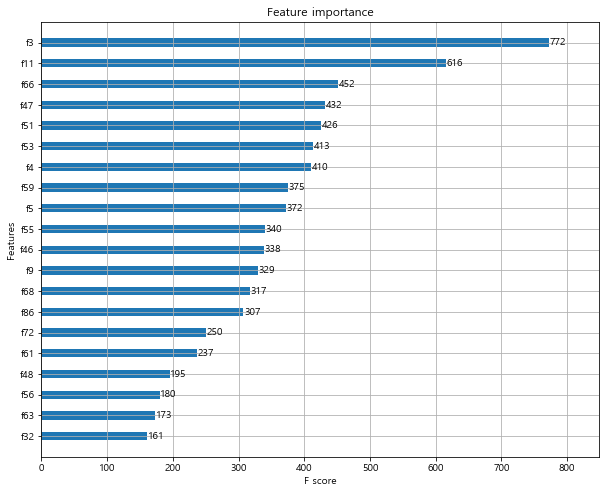

In [431]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_model, ax=ax, max_num_features=20, height=0.4)

##### 전체데이터 예측 성능 평가

In [399]:
xgb_pred = xgb_model.predict(scaled_data2)
xgb_pred_exp = np.expm1(xgb_pred)
evaluate_regr(y_target,xgb_pred_exp)

MAE : 6.446, MSE : 94.061, RMSE : 9.698, RMSLE : 0.135


In [400]:
xgb_taxi2 = taxi.set_index('o_time',inplace=False)
xgb_taxi2['pred']=xgb_pred_exp
xgb_taxi2

yesterday  today  tomorrow  temp  windspeed  humidity  \
o_time                                                                       
2018-10-01 00:00:00          1      0         0  14.1        2.6        55   
2018-10-01 01:00:00          1      0         0  13.9        2.0        57   
2018-10-01 02:00:00          1      0         0  13.9        2.4        56   
2018-10-01 03:00:00          1      0         0  13.6        1.6        56   
2018-10-01 04:00:00          1      0         0  13.7        1.9        56   
2018-10-01 05:00:00          1      0         0  13.7        1.8        57   
2018-10-01 06:00:00          1      0         0  13.3        2.3        56   
2018-10-01 07:00:00          1      0         0  13.1        2.1        58   
2018-10-01 08:00:00          1      0         0  13.7        2.4        54   
2018-10-01 09:00:00          1      0         0  14.9        3.4        50   
2018-10-01 10:00:00          1      0         0  16.3        3.6        47   
2018-10-01 11:00:00          1      0         0  17.0        4.5        45   
2018-10-01 12:00:00          1      0         0  18.4        3.5        40   
2018-10-01 13:00:00          1      0         0  17.6        4.7        49   
2018-10-01 14:00:00          1      0         0  19.3        3.5        36   
2018-10-01 15:00:00          1      0         0  19.0        3.8        40   
2018-10-01 16:00:00          1      0         0  17.7        3.4        47   
2018-10-01 17:00:00          1      0         0  17.2        2.9        53   
2018-10-01 18:00:00          1      0         0  16.6        2.9        61   
2018-10-01 19:00:00          1      0         0  16.2        2.2        62   
2018-10-01 20:00:00          1      0         0  15.4        2.1        63   
2018-10-01 21:00:00          1      0         0  14.6        4.0        66   
2018-10-01 22:00:00          1      0         0  13.9        0.5        69   
2018-10-01 23:00:00          1      0         0  13.4        3.7        69   
2018-10-02 00:00:00          0      0         1  13.0        1.8        72   
2018-10-02 01:00:00          0      0         1  12.5        1.9        74   
2018-10-02 02:00:00          0      0         1  12.3        1.6        75   
2018-10-02 03:00:00          0      0         1  11.8        0.3        78   
2018-10-02 04:00:00          0      0         1  11.2        0.3        80   
2018-10-02 05:00:00          0      0         1  10.8        0.3        82   
...                        ...    ...       ...   ...        ...       ...   
2019-03-30 18:00:00          0      1         1   4.7        4.2        66   
2019-03-30 19:00:00          0      1         1   3.7        4.9        65   
2019-03-30 20:00:00          0      1         1   3.6        4.3        68   
2019-03-30 21:00:00          0      1         1   3.7        3.7        69   
2019-03-30 22:00:00          0      1         1   3.9        3.5        69   
2019-03-30 23:00:00          0      1         1   4.1        4.2        70   
2019-03-31 00:00:00          1      1         0   3.7        3.8        72   
2019-03-31 01:00:00          1      1         0   3.4        4.4        69   
2019-03-31 02:00:00          1      1         0   3.2        4.8        70   
2019-03-31 03:00:00          1      1         0   3.3        3.4        69   
2019-03-31 04:00:00          1      1         0   3.2        3.1        69   
2019-03-31 05:00:00          1      1         0   3.2        2.9        70   
2019-03-31 06:00:00          1      1         0   3.1        3.0        69   
2019-03-31 07:00:00          1      1         0   3.0        1.5        67   
2019-03-31 08:00:00          1      1         0   3.0        2.8        63   
2019-03-31 09:00:00          1      1         0   3.1        2.6        60   
2019-03-31 10:00:00          1      1         0   3.5        3.7        58   
2019-03-31 11:00:00          1      1         0   4.2        2.7        53   
2019-03-31 12:00:00          1      1      

##### 실제값 예측값 비교

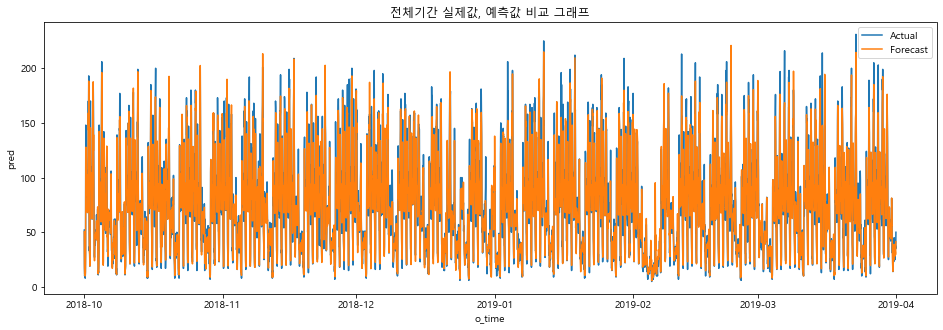

In [408]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=xgb_taxi2.index,y='count',data=xgb_taxi2)
sns.lineplot(x=xgb_taxi2.index,y='pred',data=xgb_taxi2)
plt.legend(['Actual','Forecast'])
plt.show()

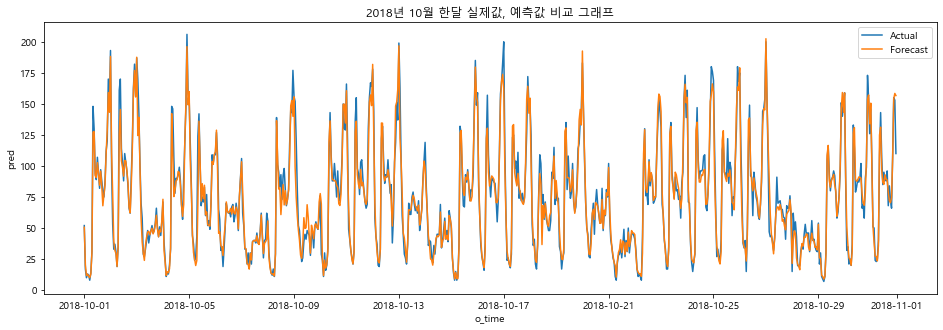

In [427]:
plt.figure(figsize=(16,5))
plt.title('2018년 10월 한달 실제값, 예측값 비교 그래프')
sns.lineplot(x=xgb_taxi2['2018-10'].index,y='count',data=xgb_taxi2['2018-10'])
sns.lineplot(x=xgb_taxi2['2018-10'].index,y='pred',data=xgb_taxi2['2018-10'])
plt.legend(['Actual','Forecast'])
plt.show()

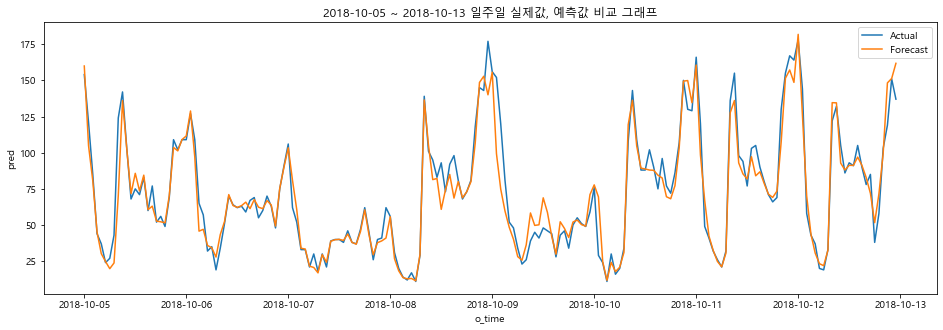

In [411]:
plt.figure(figsize=(16,5))
plt.title('2018-10-05 ~ 2018-10-13 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=xgb_taxi2['2018-10-05':'2018-10-12'].index,y='count',data=xgb_taxi2['2018-10-05':'2018-10-12'])
sns.lineplot(x=xgb_taxi2['2018-10-05':'2018-10-12'].index,y='pred',data=xgb_taxi2['2018-10-05':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

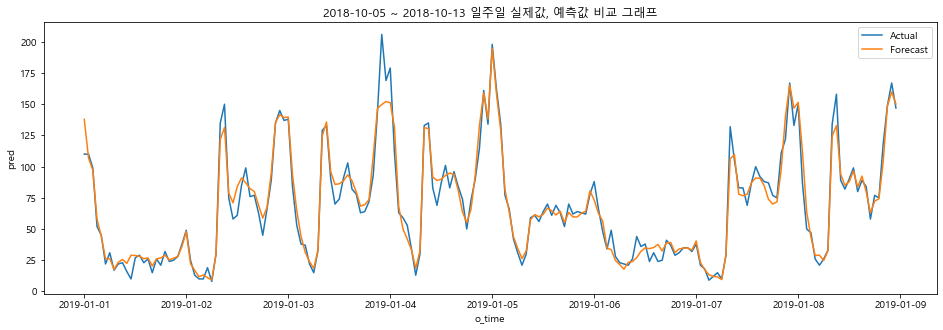

In [428]:
plt.figure(figsize=(16,5))
plt.title('2018-10-05 ~ 2018-10-13 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=xgb_taxi2['2019-01-01':'2019-01-08'].index,y='count',data=xgb_taxi2['2019-01-01':'2019-01-08'])
sns.lineplot(x=xgb_taxi2['2019-01-01':'2019-01-08'].index,y='pred',data=xgb_taxi2['2019-01-01':'2019-01-08'])
plt.legend(['Actual','Forecast'])
plt.show()